# SV1 Vtx Mass #

In SV1, the secondary vertex is uniquely defined, so the goals for this study are to 

1. Gain some understanding for how this problem changes at the reco level
2. Fit a line for the flight direction of the verteices using an optimization function 
3. Modify the cost function to fit a line that minimizes the pT.
4. Play with some different cost functions to see how the performance is increased.

Nicole Hartman
Aug 2017


In [1]:
filepath  = '/atlas/local/BtagOptimizationNtuples/user.giacinto.mc16_13TeV.410501.PowhegPythia8EvtGen_A14_ttbar_hdamp258p75.BTagNtuples.May22.JetFitterStudies.v02_Akt4EMTo/user.giacinto.11401650.Akt4EMTo._000001.root'

In [2]:
import numpy as np
import pandas as pd

# matplotlib includes
import matplotlib.pyplot as plt
import matplotlib.cm as cm # color map palatte
from matplotlib.colors import LogNorm

# rootpy functions
from root_numpy import root2array
from rootpy.vector import Vector3,LorentzVector

# useful functions that I've used in different notebooks stored in a other modules
from dataHandling import root2pandas, flatten

# ML functions
from scipy.optimize import minimize, fsolve

# Data maipulation

Take the data file from the filepath, and create a more user friendly dataframe

In [3]:
'''
Function to calculate the 3 vector for the charged trks from the SV1 algorithm

Inputs: track variables associated to a given jet (assumed to have a SV)
    jet_trk_pt:   np array of tracks pts
    jet_trk_eta:  track etas
    jet_trk_phi:  track phis
    jet_trk_alg:  binary number for which algorithms use this track, the 4th bit corresponding to SV1
    boolMask:     The boolean mask to test if the tracks came from this alg, 
                    i.e, the default 0b1000 tests SV1
            
Outputs:
    The charged particles px,py, and pz 
'''
def p_ch_trks(jet_trk_pt,jet_trk_eta,jet_trk_phi,jet_trk_alg,boolMask=0b1000):
    
    # Initialize the Vector to 0s
    p  = Vector3(0,0,0)
    pi = Vector3(0,0,0)

    for trk_pt,trk_eta,trk_phi,trk_alg in zip(jet_trk_pt,jet_trk_eta,jet_trk_phi,jet_trk_alg):

        # Check don't use tracks not used by SV1
        if trk_alg & boolMask == 0:
            continue

        pi.SetPtEtaPhi(trk_pt,trk_eta,trk_phi)
        p = p + pi

    # Scale from MeV to GeV
    p = p*0.001
    return p.Px(),p.Py(),p.Pz()


In [4]:
# A couple of other useful functions for caluclating p_perp and the corrected mass

# Calculate the perpendicular component of a vector, p, w/r.t. another vector, r
p_perp = lambda p,r : np.linalg.norm( np.cross(p,r), axis=1)/np.linalg.norm(r,axis=1)

# The corrected mass formula (depends on the invar mass of the chgd p'cles and the perpendicular
# component of the charged p'cles)
m_corr = lambda m,pt: np.sqrt(np.power(m,2) + np.power(pt,2)) + pt

# A function which scales m b/w 0 and 10
scaleM = lambda m: 5*(1 + 2/np.pi * np.arctan(np.pi*(m-5)/10.)) if m > 5 else m

# Scaling from MeV to GeV
MeVtoGeV = lambda x: x*0.001


In [109]:
loadData = True

if not loadData:

    # Select the branches that you want for this calculation
    jet_sv1_branches = ['PVx','PVy','PVz',
                        'jet_sv1_Nvtx','jet_sv1_vtx_x','jet_sv1_vtx_y','jet_sv1_vtx_z','jet_sv1_vtxm',
                        'jet_sv1_vtx_cov0','jet_sv1_vtx_cov1','jet_sv1_vtx_cov2','jet_sv1_vtx_cov3','jet_sv1_vtx_cov4','jet_sv1_vtx_cov5',
                        'jet_LabDr_HadF','jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_algo']

    # Convert the Ntuple to an nd array
    data = root2array(filepath,branches=jet_sv1_branches)

    # Go from an ndarray to a pandas data frame
    sv1_df = pd.DataFrame(data)

    # First need to convert the event level PV to jet level varaibles
    for newColumn in ['PVx','PVy','PVz']:
        sv1_df[newColumn] =  [map(lambda n_vertices: PV_x, n_vertices ) for (_, (PV_x,n_vertices))  in sv1_df[[newColumn,'jet_sv1_Nvtx']].iterrows()]

    # Flatten the array to jet level variables
    sv1_df_flat = pd.DataFrame({k: flatten(c) for k, c in sv1_df.iteritems()})
    sv1_df_flat = sv1_df_flat[sv1_df.keys()][sv1_df_flat['jet_sv1_Nvtx']==1]
    sv1_df_flat.reset_index(inplace=True,drop=True)

    # The variables in SV1 are actually stored in lists (even though there is only 1 SV / jet), so need
    # to flatten these variables one more time
    columnsToFlatten = [key for key in sv1_df.keys() if key.startswith('jet_sv1_') and 'Nvtx' not in key]
    for col in columnsToFlatten:   
        sv1_df_flat[col] =  flatten(sv1_df_flat[col]) 

    # Store the inverse of the covariance as an np.matrix
    sv1_df_flat['CovI'] = pd.Series(map(lambda cov: np.matrix([[cov[0],cov[1],cov[3]],[cov[1],cov[2],cov[4]],[cov[3],cov[4],cov[5]]]).I, 
          sv1_df_flat[['jet_sv1_vtx_cov0','jet_sv1_vtx_cov1','jet_sv1_vtx_cov2','jet_sv1_vtx_cov3','jet_sv1_vtx_cov4','jet_sv1_vtx_cov5']].values))

    # Get the flight direction (could probably do this in a for loop)
    sv1_df_flat['r0_x'] = sv1_df_flat['jet_sv1_vtx_x'] - sv1_df_flat['PVx'] 
    sv1_df_flat['r0_y'] = sv1_df_flat['jet_sv1_vtx_y'] - sv1_df_flat['PVy'] 
    sv1_df_flat['r0_z'] = sv1_df_flat['jet_sv1_vtx_z'] - sv1_df_flat['PVz'] 

    # Get the vector for the charged particles
    p_arr = np.array(map(lambda args: p_ch_trks(*args), sv1_df_flat[['jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_algo']].values))
    sv1_df_flat['p_x'] = p_arr[:,0]
    sv1_df_flat['p_y'] = p_arr[:,1]
    sv1_df_flat['p_z'] = p_arr[:,2]

    # Get the direction of pt rel to the flight path
    sv1_df_flat['pt'] = pd.Series(p_perp(sv1_df_flat[['p_x','p_y','p_z']].values,sv1_df_flat[['r0_x','r0_y','r0_z']].values))

    # Scale the vtx mass to GeV
    sv1_df_flat['m_ch'] = sv1_df_flat['jet_sv1_vtxm'].apply(lambda x: x*0.001)

    # Final (super exciting) step: Find the corrected mass :D
    sv1_df_flat['m'] = pd.Series( m_corr(sv1_df_flat['m_ch'],sv1_df_flat['pt']) )

    # Delete the columns that you don't want to save
    del_cols = ['jet_sv1_vtx_cov0','jet_sv1_vtx_cov1','jet_sv1_vtx_cov2','jet_sv1_vtx_cov3','jet_sv1_vtx_cov4','jet_sv1_vtx_cov5',
               'jet_sv1_vtxm','jet_sv1_Nvtx','jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_algo']
    for col in del_cols:
        del sv1_df_flat[col]

    # Rename some columns 
    sv1_df_flat.rename(index=str, columns={"jet_sv1_vtx_x": "SVx", "jet_sv1_vtx_y": "SVy", 
                                           "jet_sv1_vtx_z": "SVz", "jet_LabDr_HadF": "jet_pdg"},inplace=True)

# if loadData is True, load a previously formatted SV1 dataframe from an HDF5 file
else:
    sv1_df_flat = pd.read_hdf('sv1_df.h5', 'data')

In [110]:
# Look at the resultant df
sv1_df_flat[:3]

,PVx,PVy,PVz,SVx,SVy,SVz,jet_pdg,CovI,r0_x,r0_y,...,p_z,pt,m_ch,m,pt_alpha12,m_alpha12,pt_beta16,m_beta16,pt_z1,m_z1
0,-0.493256,-0.510917,1.146830,1.777389,0.201947,7.338430,5,[[[[[ 1314.8614502 -345.84637451 -401.09713...,2.270646,0.712864,...,32.702732,0.817702,1.400951,2.439830,0.817702,2.439830,0.653493,2.199364,0.695684,2.259858
1,-0.496530,-0.504810,-38.849056,-6.995791,-0.692624,-41.068386,5,[[[[[ 109.88780212 -668.6161499 -205.19377136...,-6.499261,-0.187814,...,-12.365977,1.216829,2.316980,3.833903,1.216829,3.833903,0.824535,3.283856,1.018061,3.548841
2,-0.496530,-0.504810,-38.849056,-4.370488,1.119755,-46.568710,5,[[[[[ 889.78179932 215.13705444 -380.72607422...,-3.873958,1.624565,...,-19.428242,0.276161,0.967002,1.281824,0.276161,1.281824,0.219607,1.211232,0.201239,1.188959


In [7]:
'''
Make a function that overlays the variables for the different cuts we can impose.

Inputs: 
    (1) Strings correspondings to the names of the cols of interest, i.e,
        m_ch, m, and pt
    (2) suffix: a string suffix to be appended to the titles 

'''
def overlayCuts(m_ch='m_ch', m='m', pt='pt',suffix=""):

    pdg_ids = [0,4,5,15]
    titles  = ['light jets','charm jets','b jets','tau jets']

    min = 0
    max = 10
    Nbins = 40
    range = (min,max)

    for pdg_id,title in zip(pdg_ids,titles):

        if suffix != "":
            title = "{0}: {1}".format(title,suffix)
                
        # set up your figures
        fig = plt.figure(figsize=(6, 4), dpi=100)

        plt.hist(sv1_df_flat[m_ch][sv1_df_flat['jet_pdg']==pdg_id],
                 label='$M_{ch}$', color='r',
                 histtype='step',bins=Nbins,range=range)
        plt.hist(sv1_df_flat[m][sv1_df_flat['jet_pdg']==pdg_id],
                 label='$M = \sqrt{M_{ch}^2 + p_\perp^2} + |p_\perp|$', color='b',
                 histtype='step',bins=Nbins,range=range)
        plt.hist(sv1_df_flat[m].where(sv1_df_flat[m] < 2*sv1_df_flat[m_ch],other=sv1_df_flat[m_ch])[sv1_df_flat['jet_pdg']==pdg_id],
                 label='$M < 2 M_{ch}$', color='g',
                 histtype='step',bins=Nbins,range=range)
        plt.hist(sv1_df_flat[m].where(sv1_df_flat[pt] < sv1_df_flat[m_ch],other=sv1_df_flat[m_ch])[sv1_df_flat['jet_pdg']==pdg_id],
                 label='$p_\perp < M_{ch}$', color='m',
                 histtype='step',bins=Nbins,range=range)

        # prettify your histograms
        plt.xlabel('Vtx mass [GeV]')
        plt.ylabel('Events')
        plt.title(title)
        plt.legend()
        plt.show()


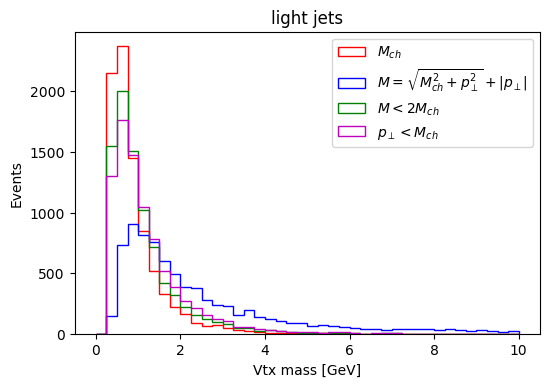

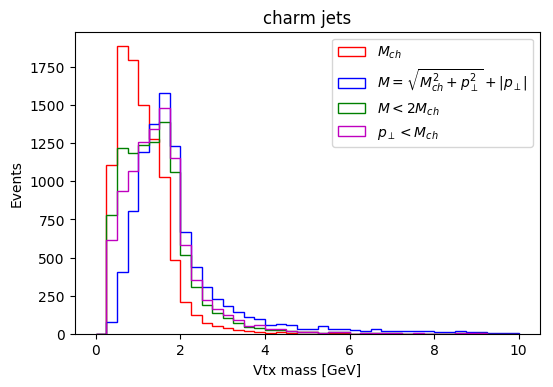

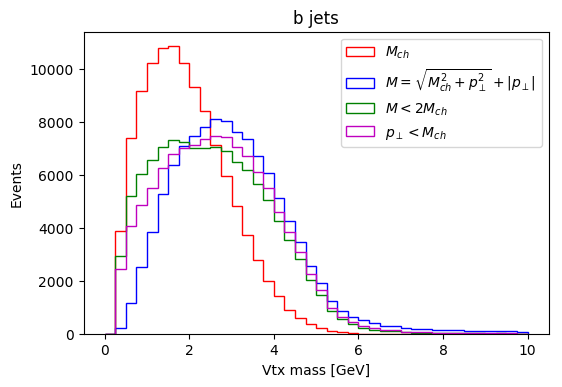

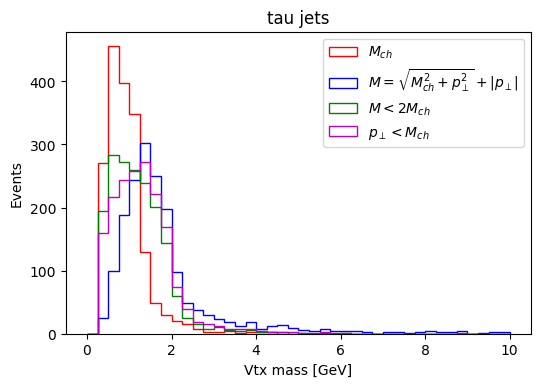

In [10]:
# Plots for the naive implementation of the formula w/o "wiggling" the SV position based on the errors

overlayCuts()

# Finding the flight direction by minimizing a cost function

Let $x_{PV}, x_{SV} \in \mathbb{R}^3$ denote the positions of the primary and secondary vertices, and $\Sigma \in \mathbb{R}^{3\times3}$ be the covariance matrix for the secondary vertex.

Let $r \in \mathbb{R}^3$ denote the flight vector of the b-hadron. The likelihood function for $r$ is given by the multi-variate Gaussian pdf: 

\begin{equation}
    \mathcal{L}(r) = p(x_{PV},x_{SV},\Sigma; r) = \frac{1}{(2\pi)^{3/2} |\Sigma|} \exp \left[ -\frac{1}{2} (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV}) \right]
\end{equation}

Maximizing this likelihood is equivalent to minimizing  $- 2 \log \mathcal{L}$ 

\begin{equation}
- 2 \log \mathcal{L} =  2 \log \left[ (2\pi)^{3/2} |\Sigma| \right] + (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV})
\end{equation}

Ignoring the constant that doesn't depend on $r$, we can then define the cost function as

\begin{equation}
J(r) = (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV})
\end{equation}

Minimizing this cost function is equivalent to simply setting $r = x_{SV} - x_{PV}$.


# Modifying the Cost function

There are a couple of different ways that we can find the flight direction to minimize $p_\perp$ 

(1) Impose a Bayesian prior on the likelihood assuming that the $p_\perp$ are Gaussian distributed about a mean of 0.

\begin{equation}
    \mathcal{L}(r) = \frac{1}{(2\pi)^{3/2} |\Sigma|} \exp \left[ -\frac{1}{2} (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV}) \right]
    \sqrt{ \frac{\alpha}{2\pi}} \exp \left( -\frac{\alpha p_\perp^2}{2}  \right)   
\end{equation}

The cost functon is again defined as $-2 \log \mathcal{L}$ (up to a constant)

\begin{align}
J(r) &= (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV}) - \alpha p_\perp^2 \\
     &= (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV}) - \alpha\left( p^2 - \left( \frac{r \cdot p}{r} \right)^2 \right)
\end{align}

This cost function is nice because you can calculate the gradient and the Hessian to minimie the objective using the rapidly converging Newton's method.

(2)  Intead of adding $\alpha p_\perp^2$ to the cost function, could instead add a term proportional to $|p_\perp|$:

\begin{align}
J(r) &= (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV}) - \beta | p_\perp | \\
     &= (r + x_{PV} - x_{SV})^T \Sigma^{-1} (r + x_{PV} - x_{SV}) - \beta \frac{|r \times p|}{|r|}
\end{align}

Note: $\alpha$ and $\beta$ are both hyperparameters that I'm free to tune, and I used different variables because they correspond to different scales.
(The function below just accepts one hyperparameter though to simplify the code.)

In [12]:
'''
Minimize J1 / J2 for a given hyperparameter alpha or beta

Global var: alpha / beta: The hyperparameter that defines how aggressively you want to minimize p_perp
            (Needs to be defined outside of this function before it's called.)

Inputs: r0:  An np.array() of length 3 pointing from the PV to the SV
        CovI: 3x3 marix for the inv of the covariance of the SV
        p:   An np.array() of length 3 for the momentum vector of the charged p'cles
        

Ouputs: r = np.array([rx,ry,rz]), the flight vector that minimizes J1

'''
def minimizeJ1(r0,CovI,p):

    invCov = np.array(CovI[0])
    J1    = lambda (r): np.dot(r-r0, np.dot(invCov, r-r0)) + alpha * (np.dot(p,p) - np.dot(r,p)**2/np.dot(r,r))
    delJ1 = lambda(r): 2*np.dot(invCov,r-r0) + 2* alpha * ( np.dot(r,p)**2 / (np.linalg.norm(r)**3) * r - np.dot(r,p) / np.dot(r,r) * p )

    res = minimize(J1,r0,method='Nelder-Mead')#,jac=delJ1)
    
    # I should probably check that the minimizer terminated successfully
    if res.success:
        return res.x
    else:
        print res.message
        return r0
    
    
def minimizeJ2(r0,CovI,p):
    
    invCov = np.array(CovI[0])
    J2 =  lambda (r): np.dot(r-r0, np.dot(invCov, r-r0)) + beta * np.linalg.norm(np.cross(p,r))/np.linalg.norm(r)

    res = minimize(J2,r0,method='Nelder-Mead')
    
    if res.success:
        return res.x
    else:
        print res.message
        return r0

In [9]:
# Try it out!
alpha=12
r_alpha12 = np.array(map(minimizeJ1 , sv1_df_flat[['r0_x','r0_y','r0_z']].values,
                sv1_df_flat[['CovI']].values,sv1_df_flat[['p_x','p_y','p_z']].values))

# Get the direction of pt rel to the flight path and the corrected mass w/ this new pt
sv1_df_flat['pt_alpha12'] = pd.Series(p_perp(sv1_df_flat[['p_x','p_y','p_z']].values,r_alpha12), index=sv1_df_flat.index)
sv1_df_flat['m_alpha12']  = pd.Series( m_corr(sv1_df_flat['m_ch'],sv1_df_flat['pt_alpha12']), index=sv1_df_flat.index)


Maximum number of function evaluations has been exceeded.


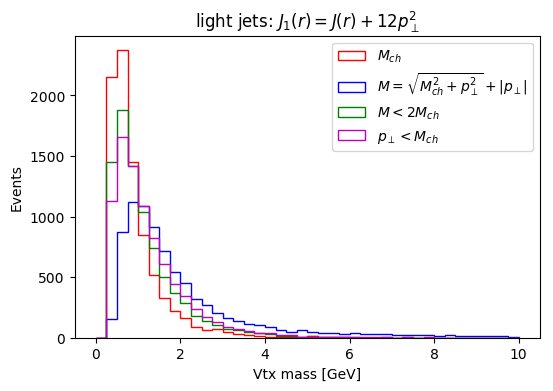

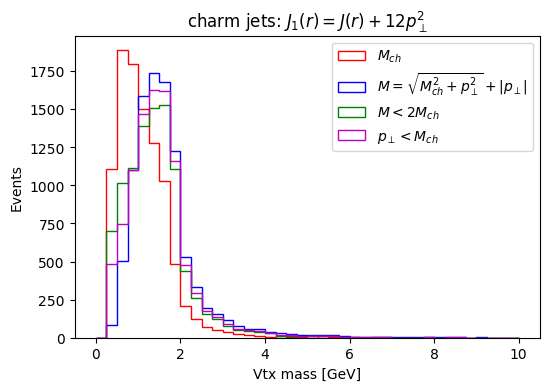

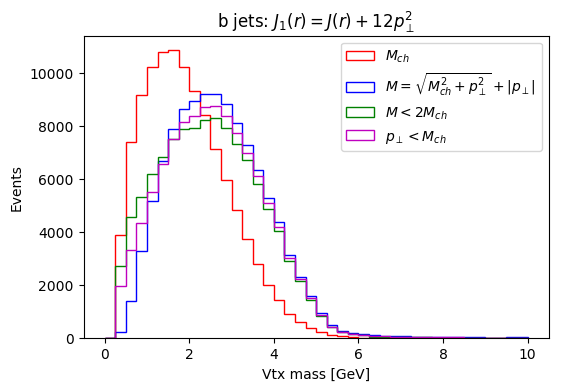

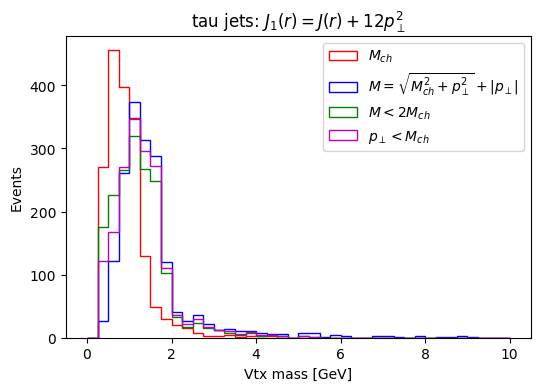

In [43]:
# Plot the histograms minimized via the J1 function
overlayCuts(m='m_alpha12',pt='pt_alpha12',suffix='$J_1(r) = J(r) + {}p_\perp^2$'.format(alpha))

In [13]:
beta = 16
r_beta16 = map(minimizeJ2 , sv1_df_flat[['r0_x','r0_y','r0_z']].values,
                sv1_df_flat[['CovI']].values,sv1_df_flat[['p_x','p_y','p_z']].values)

# Get the direction of pt rel to the flight path and the corrected mass w/ this new pt
sv1_df_flat['pt_beta16'] = pd.Series(p_perp(sv1_df_flat[['p_x','p_y','p_z']].values,r_beta16),index=sv1_df_flat.index)
sv1_df_flat['m_beta16']  = pd.Series( m_corr(sv1_df_flat['m_ch'],sv1_df_flat['pt_beta16']),index=sv1_df_flat.index )


Maximum number of function evaluations has been exceeded.
Maximum number of function evaluations has been exceeded.
Maximum number of function evaluations has been exceeded.
Maximum number of function evaluations has been exceeded.
Maximum number of function evaluations has been exceeded.


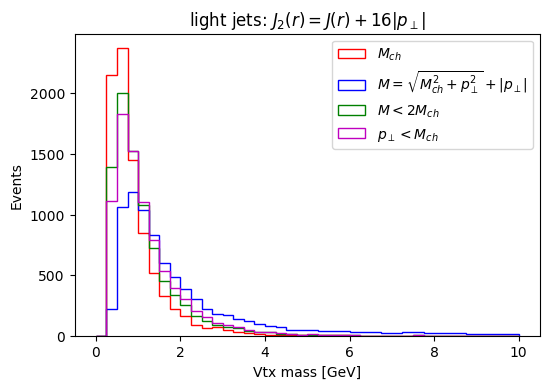

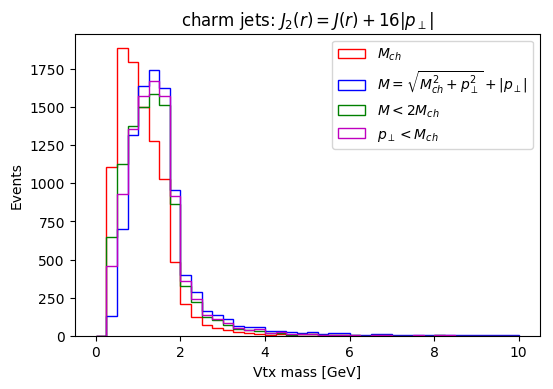

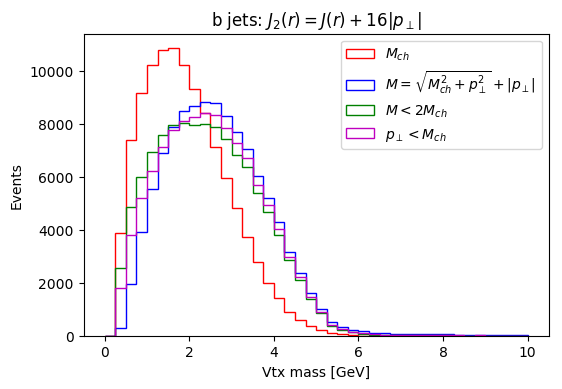

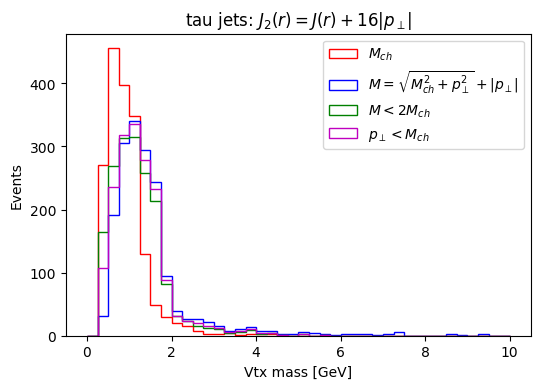

In [44]:
# Plot the histograms minimized via the J2 function
overlayCuts(m='m_beta16',pt='pt_beta16',suffix='$J_2(r) = J(r) + {}|p_\perp|$'.format(beta))

I'm going to repeat the graphs above, but this time with the cut $M < 2 M_{ch}$ for the correction formula to be applied

# Transforming a vector into the z-axis.

Let $r_0 = (x_0,y_0,z_0)$ denote a vector that you want to rotate this into the z-axis. We can do this by applying two succesive rotation matrices.

First apply a rotation $Q_1$ that rotates $r_0$ counter-clockwise about the z-axis by $\theta_1$ to set the x-component of the vector to 0.

\begin{equation}
r_1 = Q_1 r_0 = 
\begin{bmatrix} 
\cos \theta_1 & - \sin \theta_1 & 0 \\
\sin \theta_1 &   \cos \theta_1 & 0 \\
    0         &        0        & 1
\end{bmatrix}
\begin{bmatrix} 
x_0 \\
y_0 \\
z_0
\end{bmatrix}
=
\begin{bmatrix}
0 \\
y_1
z_1 = z_0
\end{bmatrix}
\end{equation}

Solving for $\cos \theta_1$:

\begin{equation}
\cos \theta_1 x_0 - \sin \theta_1 y_0 = 0
\implies x_0^2 \cos^2 \theta_1 = y_0^2 \left( 1 - \cos^2 \theta_1 \right)
\end{equation}

\begin{equation}
\cos \theta_1 = \frac{y_0}{\sqrt{x_0^2 + y_0^2}} 
\qquad \& \qquad 
\sin \theta_1 = \frac{x_0}{\sqrt{x_0^2 + y_0^2}}
\end{equation}

Then we rotate the resultant vector $r_1$ by $Q_2$ into the z-plane. 

\begin{equation}
Q_2 r_1 = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos \theta_2 & - \sin \theta_2 \\
0 & \sin \theta_2 & \cos \theta_2
\end{bmatrix}
\begin{bmatrix}
0 \\ y_1 \\ z_1
\end{bmatrix}
=
\begin{bmatrix}
0 \\ 0 \\ |r_0|
\end{bmatrix}
\end{equation}

Solving for $\theta_2$ is as $\theta_1$ with the substitution $x_0 \rightarrow y_1$ and $y_0 \rightarrow z_1$:
\begin{equation}
\cos \theta_2 = \frac{z_1}{\sqrt{y_1^2 + z_1^2}} 
\qquad \& \qquad 
\sin \theta_2 = \frac{y_1}{\sqrt{y_1^2 + z_1^2}}
\end{equation}

Then $Q = Q_2 * Q_1$ satisfies $Q r = \begin{bmatrix} 0 \\ 0 \\ |r|  \end{bmatrix}$.


In [108]:
'''
rotationMatrix() gets the transfomation matrix that rotates
a vector about two axes.

Input: r0: np.array([x,y,z])
        i: The entry that you're setting to zero
        j: The dimension that you're rotating into
    
Output: An np.matrix R such that r = R*r0 is a vector with 
        r[i] = 0 and r[j] = r0[i]**2 + r0[j]**2, with all other
        entries in r identical to those in r0.

'''
def rotationMatrix(r0,i,j,debug=True):
        
    if debug:
        print "      r0 = {0}, |r0|={1}".format(r0,np.linalg.norm(r0))

    dim = r0.size
    
    # Check that you're not trying to rotate about axes that are out of bounds
    if i >= dim or j >= dim:
        print "Index {0} not allowed for matrix of dim {1}x{1}".format(i if i >= dim else j,dim)
        sys.exit()
    
    R = np.matrix(np.identity(dim))
        
    c1 = r0[j] / np.sqrt(r0[i]**2 + r0[j]**2)
    s1 = r0[i] / np.sqrt(r0[i]**2 + r0[j]**2) 
        
    R[i,i] =  c1
    R[i,j] = -s1
    R[j,i] =  s1
    R[j,j] =  c1
        
    if debug:
        print "R*r0 = {}".format(np.dot(R,r0))

    return R

In [109]:
'''
transformationMatrix() gets the transfomation matrix that rotates
a vector r0 into the z-axis

Input: r0: np.array([x,y,z])
    
Output: An np.matrix Q such that Q*r0 = (0,0,|r0|)

'''
def transformationMatrix(r0,debug=True):
        
    if debug:
        print "      r0 = {0}, |r0|={1}".format(r0,np.linalg.norm(r0))

    Q1 = rotationMatrix(r0,0,1,debug=debug)
    r1 = np.dot(np.array(Q1),r0)
    
    if debug:
        print "   Q1*r0 = {}".format(r1)
        
    # Set the x r0 out of the () plane
    Q2 = rotationMatrix(r1,1,2,debug=debug)
    r2 = np.dot(np.array(Q2),r1)

    if debug:
        print "   Q2*r1 = {}".format(r2)
    # Same answer using the method below... it checks!
    
    Q = Q2 * Q1
    if debug:
        print "Q2*Q1*r0 = {}".format(np.dot(Q,r0))

    return Q
    

Next step: Implement the 1 sigma cut solution, most of the code will be copied and pasted from the LL plots.

In [110]:
'''
Modify the flight direction by moving the SV by 1 sigma.

Same inputs and outputs as the optimizeJ functions.

'''

def SV_1sigma(r0,CovI,p):
    
    # Transform r0 into the z-axis
    Q = transformationMatrix(r0,debug=False)

    # The number of sigmas we're transforming the SV by
    z = 1
    
    # Rotate p_arr into the flight direction of the b-hadron
    p_perp = np.dot(np.array(Q),p)

    # Find the matrix that rotates p_perp to only have a y-component
    R = rotationMatrix(p_perp,0,1,debug=False)

    # Next step: Solve for r at this J(r) = z

    # Rotate r0 by R*Q
    t0 = np.dot(np.array(R*Q),r0)
    Omega = R * Q * CovI[0] * (R*Q).T

    t = t0        
    t[1] = t0[1] + np.sqrt(z / Omega[1,1])   

    # Rotate t back into the lab frame
    r = np.dot(np.array((R*Q).T),t)
    
    return r
    

In [111]:
# Find the r modified by this 1 sigma cut, and use it to find the p_perp and corrected mass
r_z1 = np.array(map(SV_1sigma , sv1_df_flat[['r0_x','r0_y','r0_z']].values,
                sv1_df_flat[['CovI']].values,sv1_df_flat[['p_x','p_y','p_z']].values))

# Get the direction of pt rel to the flight path and the corrected mass w/ this new pt
sv1_df_flat['pt_z1'] = pd.Series(p_perp(sv1_df_flat[['p_x','p_y','p_z']].values,r_z1), index=sv1_df_flat.index)
sv1_df_flat['m_z1']  = pd.Series( m_corr(sv1_df_flat['m_ch'],sv1_df_flat['pt_z1']), index=sv1_df_flat.index)


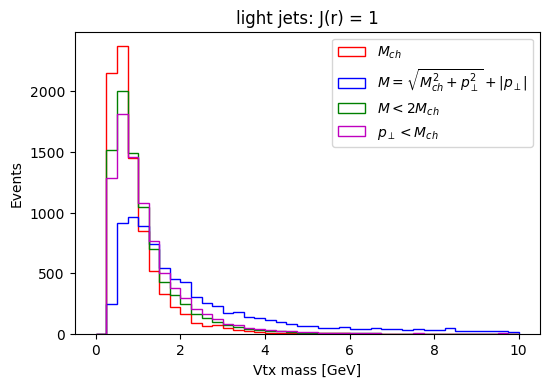

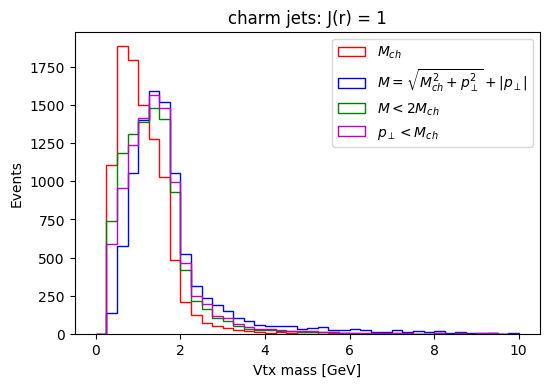

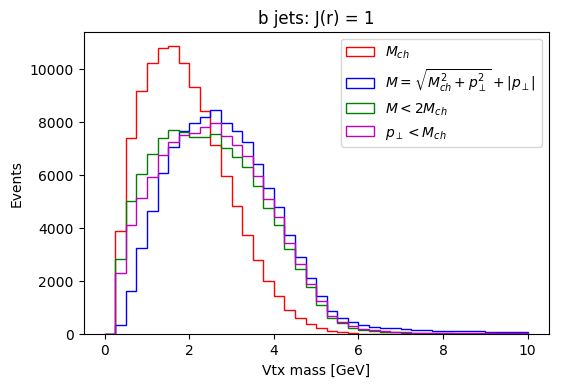

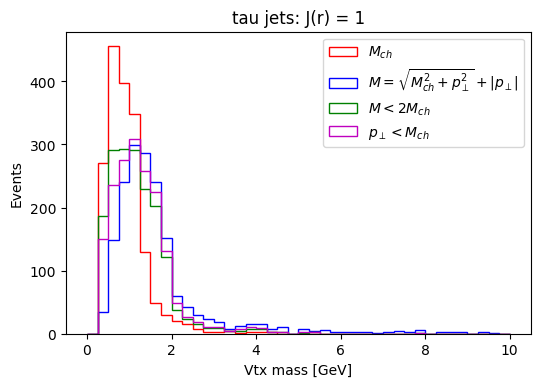

In [112]:
# Overlay the cuts
overlayCuts(m='m_z1',pt='pt_z1',suffix='J(r) = 1')

# Next Steps:
- Could try more $\alpha$s and $\beta$s, but  I'm not sure what is the error function minimize. Maybe a likelihood ratio of either the b vs c or b vs l?

Let Q be the matrix that transforms $r_0 = SV - PV$ into the z direction.


# Making the contour plots for $J(r) = z$ with respect $r_\perp$ and $p_\perp$ axes

Solving J(r) = z is equivalent to minimizing $F(r) = (J(r)-z)^2$. The solution space is in general an ellipsoid. However, since we're trying to find a new $r$ that minimizes the $p_\perp$, and in particular, look for the solution on the 2D plane,
I imposed an additional constraint that the new solution vector $r$ had the same component along the direction of $b_H$ as $r_0$, i.e, $\langle Qr|Qr_0 \rangle = \langle Q r_0|Q r_0 \rangle \implies \langle r|r_0 \rangle = \langle r_0 | r_0 \rangle$.

So to try to incorporate this constraint, I wrote the cost function in a different basis.

\begin{align}
J(r) &= (r-r_0)^T \Sigma^{-1} (r-r_0) \\
     &= (r-r_0)^T Q^T Q \Sigma^{-1} Q^T Q (r-r_0) \\
     &= (Q r - Q r_0)^T Q \Sigma^{-1} Q^T (Q r - Q r_0) \\
     &= (s - s_0)^T \Xi (s - s_0)
\end{align}

where I've defined new variables in the basis of the hadron as $s \equiv Qr$, $s_0 \equiv Qr_0$, $\Xi = Q \Sigma^{-1} Q^T$.

Then partition these vectors as
\begin{equation}
s = \begin{bmatrix} s_\perp \\ s_{||} \end{bmatrix}, \qquad
s_0 = \begin{bmatrix} 0 \\ s_0 \end{bmatrix}, \qquad
\Xi = \begin{bmatrix}\Xi_\perp \quad & \Xi_* \\ \Xi_* \quad & \Xi_{||}  \end{bmatrix}
\end{equation}

Then $ \langle s,s_0 \rangle = s_\perp \cdot 0 + s_{||} s_0 = s_0^2 \implies s_{||} = s_0$.

So $s - s_0 = \begin{bmatrix} s_\perp \\ 0 \end{bmatrix}$, and carrying out the block matrix multiplication simplifies our problem to being in only two dimensions:

\begin{equation}
J(s) = \begin{bmatrix} s_\perp^T \quad 0 \end{bmatrix}
\begin{bmatrix} \Xi_\perp \quad & \Xi_* \\ \Xi_* \quad & \Xi_{||}  \end{bmatrix}
\begin{bmatrix} s_\perp \\ 0 \end{bmatrix}
= s_\perp^T \Xi_\perp s_\perp
\end{equation}

\begin{equation}
\nabla_s (J(s) - z)^2 = 2(J(s) - z) \nabla_s J(s) = 4 (J(s) - z) \Xi_\perp s_\perp
\end{equation}

So this gradient doesn't change anything in the flight direction.

Then for some initial guess, the minimizer will return a s value. Transform $s$ back to the lab frame to get a solution $r = Q^T s$. 

Then to get $p_\perp$ with respect to the new axis, I found the $Q'$ for the flight direction along r, and then applied $Q' * p = \begin{bmatrix} p_{\perp 1} \\ p_{\perp 2} \\ p_{||} \end{bmatrix}$.

Then to get the whole contour of solutions, I passed in a range of different initial guesses for $r$, and concentric squares as inititial guesses for r allowed me to fill out the ellipse of solutions in $r_\perp$ and get a connected contours for $s_\perp$ as well. 


In [113]:
'''
Function 'getInitialGuess()' returns the initial guesses for flight direction r found 
from solving the equation J(r)=z.
From trying a few different choices for initial guesses, it seemed like
two concentric squares allowed full coverage of the solution vector curve

I've done a bit of tuning to adjust the boxes to be the right size to get
the cover the allowed rs.

Inputs:
    z:           Float - the sigma for which this contour was generated
    N:           Integer - the number points along each side of the square
    x3:          The z coordinate for the position (along the flight axis)
                 Note: The solution to minimizer is currently dependent
                 on having the z value correct.
    drawSquares: Boolean - True if you want to plot the initial guess
    drawSolnR:   Boolean - True if the solution to the minimizer should be
                 plotted along with the initial guess.
Outputs:
    items:     A list of dimensions (8*(N+1), 3) for the (x,y,z) positions
               for the initial guesses to be passed to the minimizer.
               The factor of 8 is for the 8 sides of the two squares
'''
def getInitialGuess(z=1,N=10,x3=0,drawSquares=True,drawSolnR=False):
    
    if z > 0.8:
        boxSizes = [0.01,0.02,0.03]
    elif z > .6:
        boxSizes =[0.02,0.025,0.0275]
    elif z > .4:
        boxSizes =[0.01,0.015,0.02]
    else:
        boxSizes =[0.012,0.019]

    # Change the dimensions of this var depending on what z is passed in
    
    boxColors  = ['c','g','m']
    solnColors = ['r','b','k']
    
    items = []
    
    if drawSquares or drawSolnR:
        plt.figure(figsize=(5, 5))
    
    for boxSize,boxColor,solnColor in zip(boxSizes,boxColors,solnColors):
        l1 = np.linspace(-boxSize,boxSize,N)
        l2 = boxSize*np.ones(N)
        myItems = map(lambda x,y: (x,y,x3), np.concatenate([l1,l2,l1,-l2]),np.concatenate([l2,l1,-l2,-l1]))
        
        # Draw the lines - if requested
        if drawSquares:
            plt.scatter(np.array(myItems)[:,0],np.array(myItems)[:,1],label="Intial guess, s = {}".format(boxSize),color=boxColor)

        # Note: The cell below needs to be executed before
        if drawSolnR:
            results = np.array( map(lambda si: minimize(J_z1_Sqd , si, jac=delJ_Sqd).x, myItems) )
            plt.scatter(results[:,0],results[:,1],label="Soln r for r0 from s = {} square".format(boxSize),color=solnColor)
        
        # Append to items
        items = items + myItems

    # If a figure was drawn, display it 
    if drawSquares or drawSolnR:
        # Add labels for the x and y axis
        plt.title('z = {0}; # points / line seg = {1}'.format(z,N))
        plt.xlabel('$r_{\perp 1}$')
        plt.ylabel('$r_{\perp 2}$')
        plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
        
    # Don't bother showing the figure if you're calling the function
    # from the optimizeJ function.
    if drawSolnR:
        plt.show()

    return items
 

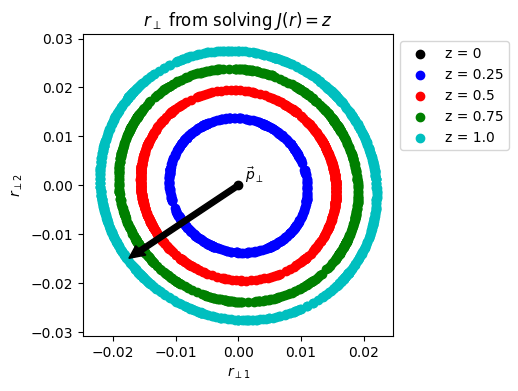

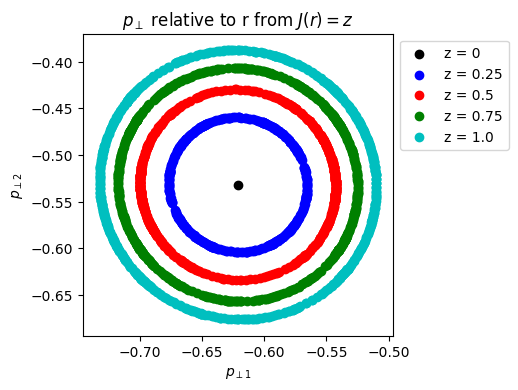

In [114]:
# Make the contour plots for the solution of ellipses satisfying J(r) = z perpendicular the dir of the hadron
plt.close()

invCov = sv1_df_flat['CovI'][0]

# Initialize the flight direction of the b-hadron to the SV - PV
# It turns out that the first event that has a SV is a b-hadron
r0 = sv1_df_flat[['SVx','SVy','SVz']].values[0] - sv1_df_flat[['PVx','PVy','PVz']].values[0]
Q = transformationMatrix(r0,debug=False)
r2 = np.dot(np.array(Q),r0)
        
# Solve for the vector s_perp
Chi = Q * invCov * Q.T

# Plot the center of the ellipse
fig = plt.figure(figsize=(4, 4), dpi=100, facecolor='white')
#plt.figure(1)
plt.scatter(r2[0],r2[1],color='k',label='z = 0')

# Define the p_perp plot outside of the for loop
fig = plt.figure(figsize=(4, 4), dpi=100, facecolor='white')
#plt.figure(2)
p_arr = sv1_df_flat[['p_x','p_y','p_z']].values[0]
my_pPerp = np.dot(np.array(Q),p_arr)
plt.scatter(my_pPerp[0],my_pPerp[1],color='k',label='z = 0')

# Rotate the momentum vector into the new basis
my_arrow = np.dot(np.array(Q),p_arr)
# Scale the momentum vector to not overwhelm the r contours figure
scaledArrow = 0.025*my_arrow;
plt.figure(1)
plt.arrow(0, 0, scaledArrow[0], scaledArrow[1], head_width=0.0025, head_length=0.0025, fc='k', ec='k')
plt.text(0.001, 0.001, r'$\vec{p}_\perp$')


# Loop over the different sigmas you're setting the cost function = to for the contour plots
for z,color in zip([0.25,0.5,0.75,1.0],['b','r','g','c']):

    J   = lambda(s): np.dot(s-r2,np.dot(np.array(Chi),s-r2))

    # Next: Find a solution to the eqn J(r_new,alpha=1) = 1 in the plane transverse to the flight dir
    J_z1_Sqd = lambda (s): np.power((J(s) - z) , 2)

    # The gradient of the function we're trying to minimize
    delJ_Sqd = lambda(s): 4*(J(s)-z) * np.append(np.dot(np.array(Chi)[:2,:2] , (s-r2)[:2]),0)

    # Get the initial guess for the points from this z value
    items = getInitialGuess(z=z,N=50,x3=r2[2],drawSquares=False,drawSolnR=False)

    results = np.array( map(lambda si: minimize(J_z1_Sqd , si, jac=delJ_Sqd).x, items) )

    plt.figure(1)
    plt.scatter(results[:,0],results[:,1],color=color,label='z = {}'.format(z))

    # Next: Plot the contours for the LL on the pT axes
    # To do this, we'll need to define p_perp1 and p_per2 relative to the new flight direction, i.e, 
    # find a new transformation matrix Qprime assuming that some new rprime is the hadron's flight dir.
    p_newAxis = np.array( map(lambda r: np.dot(np.array(transformationMatrix(np.dot(np.array(Q.T),r),debug=False)),p_arr), results) )

    # plot a new figure for the pt
    plt.figure(2)
    plt.scatter(p_newAxis[:,0],p_newAxis[:,1],color=color,label='z = {}'.format(z))

# Display the figures
# Set the axes and legends for the figures
plt.figure(1)
plt.title('$r_\perp$ from solving $J(r) = z$')
plt.xlabel('$r_{\perp 1}$')
plt.ylabel('$r_{\perp 2}$') 
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.figure(2)
plt.title('$p_\perp$ relative to r from $J(r) = z$')
plt.xlabel('$p_{\perp 1}$')
plt.ylabel('$p_{\perp 2}$')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.show()


# Moving the SV in the  direction of the charged particles

Start from the simplified cost function:

\begin{equation}
J(s) = s_\perp^T \Xi s_\perp
\end{equation}

and then find a new transformation matrix R that rotates $p_\perp$ in the y-direction:
\begin{equation}
R \begin{bmatrix} p_{\perp 1} \\ p_{\perp 1} \end{bmatrix} 
= \begin{bmatrix} 0 \\ |p_\perp | \end{bmatrix},
\qquad
R \begin{bmatrix} s_{\perp 1} \\ s_{\perp 2} \end{bmatrix} 
= \begin{bmatrix} t_1 \\ t_2 \end{bmatrix},
\qquad
R \begin{bmatrix} s_{0 \perp 1} \\ s_{0 \perp 2} \end{bmatrix} 
= \begin{bmatrix} t_{0_1} \\ t_{0_2} \end{bmatrix}
\end{equation}

Then since $R p_\perp$ is in the y direction, we only want to to wiggle the flight direction
vector in the y direction, i.e,
$t_{0_1} = t_1 \implies t - t_0 = \begin{bmatrix} 0 \\ t_2 - t_{0_2} \end{bmatrix}$.

So modify the cost function (again):

\begin{equation}
J(s) = s_\perp^T \Xi s_\perp = s_\perp^T R^T R \Xi R^T R s_\perp
\end{equation}

Let $\Omega = \begin{bmatrix} \Omega_{11} \quad & \Omega_{12} \\ \Omega_{21} \quad & \Omega_{22}\end{bmatrix}$, then
                
\begin{equation}
J(t) = \begin{bmatrix} 0 \quad t_2 - t_{0_2} \end{bmatrix}
\begin{bmatrix} \Omega_{11} \quad & \Omega_{12} \\ \Omega_{21} \quad & \Omega_{22}\end{bmatrix}
\begin{bmatrix} 0 \\ t_2 - t_{0_2} \end{bmatrix}
= (t_2 - t_{0_2}) \Omega_{22} (t_2 - t_{0_2}) = z
\end{equation}
where $z$ is the number of standard deviations away from the SV that you're allowed to move, i.e, $z=1$.

This is now simply a quadratic formula that you can solve for the unknown $t_2$.

\begin{equation}
t_2 = t_{0_2} \pm \sqrt{\frac{z}{\Omega_{22}}}
\end{equation}

How do we decide which root to choose?
We want to mininize the projection of $p_\perp$ along the flight axis.
\begin{align}
\langle p, r \rangle &= \langle R Q p, R Q r \rangle \\
&= 0 \cdot t_1 + |p_\perp| \left( t_{0_2} \pm \sqrt{\frac{z}{\Omega_{22}}} \right) + p_{||} \cdot s_{||}
\end{align}
So choose the $+$ root to maximize this projection.

Let $R' = \begin{bmatrix} R \quad &\begin{matrix} 0 \\ 0 \end{matrix} \\ 0 \quad 0 \quad & 1 \end{bmatrix}$. Then we can transform back to the lab frame to get the $r$ that we're calculating $p_\perp$ with respect to.
\begin{equation}
r = Q^T (R')^T t, \quad \text{where} \begin{bmatrix} t_{0_1} \\ t_{0_2} \\ s_{||} \end{bmatrix}.
\end{equation}


In [115]:
# Save the dataframe for future use!
sv1_df_flat.to_hdf('sv1_df.h5', 'data')

# Note: The warning message for the np.matrix() column is fine - I can still load the data ok

# Get the truth info / preprocess this data

I think the only variables I need are the pdg id, m_ch, p_perp, m, and the mass of the hadron, and I can get this info from the branches:
'jet_bH_pt','jet_bH_eta','jet_bH_phi','jet_bH_E','jet_bH_child_px','jet_bH_child_py','jet_bH_child_pz','jet_bH_child_E'

and possibly: 'jet_bH_nBtracks','jet_bH_nCtracks'



In [6]:
# Go from ATLAS coordinates to Cartesian 
def get_r(pt,eta,phi):
    r = Vector3()
    r.SetPtEtaPhi(pt,eta,phi)

    # Scale to have norm 1
    r = r.Unit()
    
    return r.X(),r.Y(),r.Z()

In [7]:
# Function to calculate m_ch from a set of tracks
def truth_m_ch(trk_pxs,trk_pys,trk_pzs,trk_Es,nTrks):

    pi= LorentzVector(0,0,0,0)
    p = LorentzVector(0,0,0,0)

    for trk_px,trk_py,trk_pz,trk_E in zip(trk_pxs[:nTrks],trk_pys[:nTrks],trk_pzs[:nTrks],trk_Es[:nTrks]):
        pi.SetPxPyPzE(trk_px,trk_py,trk_pz,trk_E)
        p = p + pi

    return p.M()

In [9]:
# '''
# New try: Preprocess the data but add an extra leaf for jet_type
# '''

loadTruth = False

if not loadTruth:

    # Turn off the warnings for setting values from copied arrays
    pd.options.mode.chained_assignment = None
    
    # Select the branches that you want for this calculation
    branches = ['jet_bH_pt','jet_bH_eta','jet_bH_phi','jet_bH_E','jet_bH_MTrk','jet_bH_pdgId',
                      'jet_bH_child_px','jet_bH_child_py','jet_bH_child_pz','jet_bH_child_E',
                      'jet_bH_nBtracks','jet_bH_nCtracks',
                 'jet_cH_pt','jet_cH_eta','jet_cH_phi','jet_cH_E','jet_cH_MTrk','jet_cH_pdgId',
                      'jet_cH_child_px','jet_cH_child_py','jet_cH_child_pz','jet_cH_child_E',
                      'jet_cH_nCtracks']

    # Convert the Ntuple to an nd array
    data = root2array(filepath,branches=branches)

    # Go from an ndarray to a pandas data frame
    df = pd.DataFrame(data)

    # Flatten the array to jet level variables
    df_flat = pd.DataFrame({k: flatten(c) for k, c in df.iteritems()})
    df_flat.reset_index(inplace=True,drop=True)

    # The hadron variables are actually stored in lists (although only rarely is there more than
    # on hadron / jet), so need to flatten these variables one more time
    columnsToFlatten = [key for key in df_flat.keys() if key.startswith('jet_') and 'child' not in key]
    for col in columnsToFlatten:   
        df_flat[col] =  pd.Series([x[0] for x in df_flat[col].values])

    ##########################################################################
    #
    # Only select events for this df that have a b-hadron
    #
    ##########################################################################
    df1_flat = df_flat[df_flat['jet_bH_pt']!=-99]
    df1_flat.reset_index(inplace=True,drop=True)

    df1_flat['nTrks']=df1_flat['jet_bH_nBtracks'] + df1_flat['jet_bH_nCtracks']
  
    df1_flat['trk_px'] = df1_flat['jet_bH_child_px'].apply(MeVtoGeV)
    df1_flat['trk_py'] = df1_flat['jet_bH_child_py'].apply(MeVtoGeV)
    df1_flat['trk_pz'] = df1_flat['jet_bH_child_pz'].apply(MeVtoGeV)
    df1_flat['trk_E']  = df1_flat['jet_bH_child_E'].apply(MeVtoGeV)

    # Get the flight direction of the hadron
    r = np.array(map(get_r,df1_flat['jet_bH_pt'],df1_flat['jet_bH_eta'],df1_flat['jet_bH_phi'])) 
    print "r.shape = {0}, len(index) = {1}".format(r.shape,len(df1_flat.index))
    df1_flat['r0_x'] = r[:,0]
    df1_flat['r0_y'] = r[:,1]
    df1_flat['r0_z'] = r[:,2]
    
    # Scale the hadron mass to GeV
    df1_flat['m_ch'] = df1_flat['jet_bH_MTrk'].apply(MeVtoGeV)
    
    # Get the momentum of the jet and the mass of the hadron
    df1_flat['jet_p']    = df1_flat['jet_bH_pt']*np.cosh(df1_flat['jet_bH_eta']).apply(MeVtoGeV)
    df1_flat['m_hadron'] = np.sqrt( np.power(df1_flat['jet_bH_E'],2) - np.power(df1_flat['jet_p'],2) ).apply(MeVtoGeV)

    df1_flat['jet_LabDrF'] = 5*np.ones(len(df1_flat.index))
        
    
    #######################################################
    #
    # Repeat for the c-hadron
    #
    ############################################# #########

    # Only select events for this df that have a c-hadron
    df2_flat = df_flat[df_flat['jet_cH_pt']!=-99] 
    df2_flat.reset_index(inplace=True,drop=True)
    
    df2_flat['nTrks'] = df2_flat['jet_cH_nCtracks']
    
    # Get the momentum vector of the chgd p'cles (in GeV)
    df2_flat['trk_px'] = df2_flat['jet_cH_child_px'].apply(MeVtoGeV)
    df2_flat['trk_py'] = df2_flat['jet_cH_child_py'].apply(MeVtoGeV)
    df2_flat['trk_pz'] = df2_flat['jet_cH_child_pz'].apply(MeVtoGeV)
    df2_flat['trk_E']  = df2_flat['jet_cH_child_E'].apply(MeVtoGeV)

    # Get the flight direction of the hadron
    r = np.array(map(get_r,df2_flat['jet_cH_pt'],df2_flat['jet_cH_eta'],df2_flat['jet_cH_phi'])) 
    print "r.shape = {0}, len(index) = {1}".format(r.shape,len(df2_flat.index))
    df2_flat['r0_x'] = r[:,0]
    df2_flat['r0_y'] = r[:,1]
    df2_flat['r0_z'] = r[:,2]
    
    # Scale the vtx mass to GeV
    df2_flat['m_ch'] = df2_flat['jet_cH_MTrk'].apply(MeVtoGeV)

    # Get the momentum of the jet and the mass of the hadron
    df2_flat['jet_p']    = (df2_flat['jet_cH_pt']*np.cosh(df2_flat['jet_cH_eta'])).apply(MeVtoGeV)
    df2_flat['m_hadron'] = (np.sqrt( np.power(df2_flat['jet_cH_E'],2) - np.power(df2_flat['jet_p'],2) )).apply(MeVtoGeV)
    
    df2_flat['jet_LabDrF'] = 4*np.ones(len(df2_flat.index))
        
    #####################################################################
    # Delete the columns that you don't want to save
    # so df1_flat and df2_flat have the same information
    #####################################################################
    for branch in branches:
        del df1_flat[branch]
        del df2_flat[branch]    
    
    # Concatenate the dfs
    truth_df = pd.concat([df1_flat,df2_flat])  
    truth_df.reset_index(inplace=True,drop=True)
    
    # Find the p_perps for each of the tracks for the scalar sum comparison
    truth_df['trk_pt'] = pd.Series([np.array([ np.linalg.norm(np.cross(np.array([pxi,pyi,pzi]),r0)) for pxi,pyi,pzi in zip(px[:ntrks],py[:ntrks],pz[:ntrks])]) for px,py,pz,r0,ntrks in zip(truth_df['trk_px'],truth_df['trk_py'],truth_df['trk_pz'],truth_df[['r0_x','r0_y','r0_z']].values,truth_df['nTrks'])]) 
    
    # Do the mass scaling steps, considering the possibility that you could drop tracks
    for droppedTrks in np.arange(3):
        
        # Set up a naming convention for how many truth tags you're dropping
        if droppedTrks != 0:
            prevTag=tag 
        tag = "" if droppedTrks == 0 else "_drop{}trk".format(droppedTrks)
        
        # Need to recalculate m_ch if droppedTracks > 0
        if droppedTrks != 0:
            truth_df['nTrks'+tag] = (truth_df['nTrks']-droppedTrks).where(truth_df['nTrks']>droppedTrks,other=truth_df['nTrks'+prevTag])
            truth_df['m_ch'+tag] = pd.Series(map(lambda args: truth_m_ch(*args) , truth_df[['trk_px','trk_py','trk_pz','trk_E','nTrks'+tag]].values))
    
            
        # If droppedTracks != 0, calculate the charged mass of the tracks
        truth_df['p_x'+tag] = pd.Series([ sum(x[:nTrks]) for x,nTrks in zip(truth_df['trk_px'],truth_df['nTrks'+tag]) ])
        truth_df['p_y'+tag] = pd.Series([ sum(x[:nTrks]) for x,nTrks in zip(truth_df['trk_py'],truth_df['nTrks'+tag]) ])
        truth_df['p_z'+tag] = pd.Series([ sum(x[:nTrks]) for x,nTrks in zip(truth_df['trk_pz'],truth_df['nTrks'+tag]) ])

        # Find the p_perp and get the mass correction 
        truth_df['pt'+tag] = pd.Series(p_perp(truth_df[['p_x'+tag,'p_y'+tag,'p_z'+tag]].values,truth_df[['r0_x','r0_y','r0_z']].values))
        truth_df['m'+tag]  = pd.Series(m_corr(truth_df['m_ch'+tag],truth_df['pt'+tag]) )

        # Find the scalar sum for the p_perp
        
        truth_df['pt_SS'+tag] = pd.Series( np.sum(pts[:ntrks]) for pts,ntrks in zip(truth_df['trk_pt'],truth_df['nTrks'+tag]) )
        truth_df['m_raw_SS'+tag] = pd.Series(m_corr(truth_df['m_ch'+tag],truth_df['pt_SS'+tag])) 
        # Only apply the correction if m_ch is greater than 0
        truth_df['m_raw_SS'+tag] = truth_df['m_raw_SS'+tag].where(truth_df['m_ch'+tag] > 0,other=truth_df['m_ch'+tag])
        # Don't let the correction go above 10 GeV
        truth_df['m_scaled_SS'+tag] = truth_df['m_raw_SS'+tag].apply(scaleM)

    
    # Save the processed data for future use 
    truth_df.to_hdf('truth_df.h5', 'data')
    
# if loadData is True, load a previously formatted dataframe from an HDF5 file
else:
    truth_df = pd.read_hdf('truth_df.h5', 'data')

r.shape = (16848, 3), len(index) = 16848
r.shape = (20547, 3), len(index) = 20547


/nfs/slac/g/atlas/u02/makagan/miniconda3/envs/mlenv2/lib/python2.7/site-packages/pandas/core/generic.py:1282: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['trk_px', 'trk_py', 'trk_pz', 'trk_E', 'trk_pt']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [85]:
truth_df[['pt_SS','pt_SS_drop1trk','pt_SS_drop2trk','m_ch','m_ch_drop1trk','m_ch_drop2trk','nTrks','nTrks_drop1trk','nTrks_drop2trk']][:5]

,pt_SS,pt_SS_drop1trk,pt_SS_drop2trk,m_ch,m_ch_drop1trk,m_ch_drop2trk,nTrks,nTrks_drop1trk,nTrks_drop2trk
0,1.767468,1.347689,1.115576,2.492002,1.894354,1.218488,5,4,3
1,2.040469,1.642935,1.247358,2.296278,1.946935,1.408154,5,4,3
2,0.677205,0.479503,0.249864,0.964390,0.488664,0.139561,3,2,1
3,2.150496,0.549825,0.549825,2.257980,0.139629,0.139629,2,1,1
4,0.928048,0.886255,0.457895,2.212445,2.055734,1.601362,4,3,2


In [13]:
# This is a little disconcerting... sometimes there aren't ANY charged tracks from the hadrons
# How does this respect charge conservation?

# This happens for 27 of the b-hadrons
#truth_df[truth_df['nTrks']==0]

# This happens for 1003 events for the c-hadrons
#truth_df.loc['c'][truth_df.loc['c']['nTrks']==0]

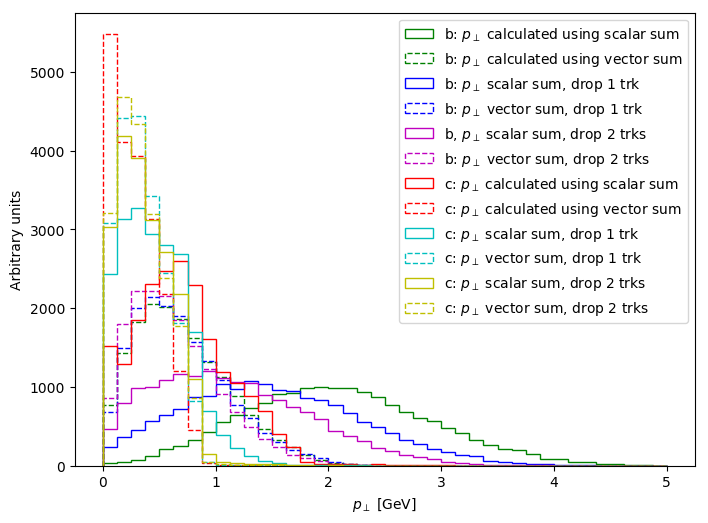

In [10]:
# Overlay the truth pPerp and mass distributions calculated with the scalar sum and vector summed versions for pPerp
Nbins=40
range=(0,5)

plt.figure(figsize=(8, 6), dpi=100)

# b-hadrons
plt.hist(truth_df['pt_SS'][truth_df['jet_LabDrF']==5],color='g',linestyle='solid',
        histtype='step',bins=Nbins,range=range,label='b: $p_\perp$ calculated using scalar sum')
plt.hist(truth_df['pt'][truth_df['jet_LabDrF']==5],color='g',linestyle='dashed',histtype='step',
         bins=Nbins,range=range,label='b: $p_\perp$ calculated using vector sum')

plt.hist(truth_df['pt_SS_drop1trk'][truth_df['jet_LabDrF']==5],color='b',linestyle='solid',
        histtype='step',bins=Nbins,range=range,label='b: $p_\perp$ scalar sum, drop 1 trk')
plt.hist(truth_df['pt_drop1trk'][truth_df['jet_LabDrF']==5],color='b',linestyle='dashed',histtype='step',
         bins=Nbins,range=range,label='b: $p_\perp$ vector sum, drop 1 trk')

plt.hist(truth_df['pt_SS_drop2trk'][truth_df['jet_LabDrF']==5],color='m',linestyle='solid',
        histtype='step',bins=Nbins,range=range,label='b, $p_\perp$ scalar sum, drop 2 trks')
plt.hist(truth_df['pt_drop2trk'][truth_df['jet_LabDrF']==5],color='m',linestyle='dashed',histtype='step',
         bins=Nbins,range=range,label='b: $p_\perp$ vector sum, drop 2 trks')


# c-hadrons
plt.hist(truth_df['pt_SS'][truth_df['jet_LabDrF']==4],color='r',linestyle='solid',histtype='step',
         bins=Nbins,range=range,label='c: $p_\perp$ calculated using scalar sum')
plt.hist(truth_df['pt'][truth_df['jet_LabDrF']==4],color='r',linestyle='dashed',histtype='step',
         bins=Nbins,range=range,label='c: $p_\perp$ calculated using vector sum')

plt.hist(truth_df['pt_SS_drop1trk'][truth_df['jet_LabDrF']==4],color='c',linestyle='solid',histtype='step',
         bins=Nbins,range=range,label='c: $p_\perp$ scalar sum, drop 1 trk')
plt.hist(truth_df['pt_drop1trk'][truth_df['jet_LabDrF']==4],color='c',linestyle='dashed',histtype='step',
         bins=Nbins,range=range,label='c: $p_\perp$ vector sum, drop 1 trk')

plt.hist(truth_df['pt_SS_drop2trk'][truth_df['jet_LabDrF']==4],color='y',linestyle='solid',histtype='step',
         bins=Nbins,range=range,label='c: $p_\perp$ scalar sum, drop 2 trks')
plt.hist(truth_df['pt_drop2trk'][truth_df['jet_LabDrF']==4],color='y',linestyle='dashed',histtype='step',
         bins=Nbins,range=range,label='c: $p_\perp$ vector sum, drop 2 trks')


plt.xlabel('$p_\perp$ [GeV]')
plt.ylabel('Arbitrary units')
plt.legend()
plt.show()


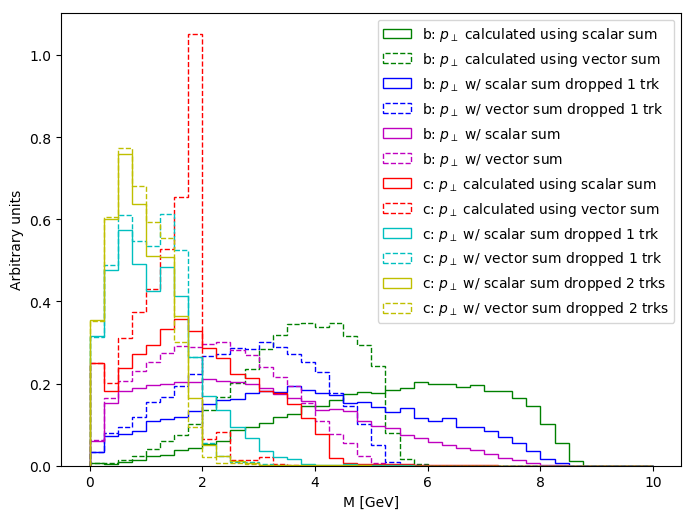

In [13]:
# Overlay the truth pPerp and mass distributions calculated with the scalar sum and vector summed versions for pPerp
Nbins=40
range=(0,10)

plt.figure(figsize=(8, 6), dpi=100)

# b-hadrons
b_n_SS,     edges,_ = plt.hist(truth_df[truth_df['jet_LabDrF']==5]['m_scaled_SS'],color='g',linestyle='solid',
        histtype='step',bins=Nbins,range=range,normed=True,label='b: $p_\perp$ calculated using scalar sum')
b_n_VS,     edges,_ = plt.hist(truth_df[truth_df['jet_LabDrF']==5]['m'],color='g',linestyle='dashed',histtype='step',
         bins=Nbins,range=range,normed=True,label='b: $p_\perp$ calculated using vector sum')

b_n_SS_1trk,edges,_ = plt.hist(truth_df[truth_df['jet_LabDrF']==5]['m_scaled_SS_drop1trk'],color='b',linestyle='solid',
        histtype='step',bins=Nbins,range=range,normed=True,label='b: $p_\perp$ w/ scalar sum dropped 1 trk')
b_n_VS_1trk,edges,_ = plt.hist(truth_df[truth_df['jet_LabDrF']==5]['m_drop1trk'],color='b',linestyle='dashed',histtype='step',
         bins=Nbins,range=range,normed=True,label='b: $p_\perp$ w/ vector sum dropped 1 trk')

b_n_SS_2trk,edges,_ = plt.hist(truth_df[truth_df['jet_LabDrF']==5]['m_scaled_SS_drop2trk'],color='m',linestyle='solid',
        histtype='step',bins=Nbins,range=range,normed=True,label='b: $p_\perp$ w/ scalar sum')
b_n_VS_2trk,edges,_ = plt.hist(truth_df[truth_df['jet_LabDrF']==5]['m_drop2trk'],color='m',linestyle='dashed',histtype='step',
         bins=Nbins,range=range,normed=True,label='b: $p_\perp$ w/ vector sum')


# c-hadrons
c_n_SS,     edges,_ = plt.hist(truth_df[truth_df['jet_LabDrF']==4]['m_scaled_SS'],color='r',linestyle='solid',histtype='step',
         bins=Nbins,range=range,normed=True,label='c: $p_\perp$ calculated using scalar sum')
c_n_VS,     edges,_ = plt.hist(truth_df[truth_df['jet_LabDrF']==4]['m'],color='r',linestyle='dashed',histtype='step',
         bins=Nbins,range=range,normed=True,label='c: $p_\perp$ calculated using vector sum')

c_n_SS_1trk,edges,_ = plt.hist(truth_df[truth_df['jet_LabDrF']==4]['m_scaled_SS_drop1trk'],color='c',linestyle='solid',histtype='step',
         bins=Nbins,range=range,normed=True,label='c: $p_\perp$ w/ scalar sum dropped 1 trk')
c_n_VS_1trk,edges,_ = plt.hist(truth_df[truth_df['jet_LabDrF']==4]['m_drop1trk'],color='c',linestyle='dashed',histtype='step',
         bins=Nbins,range=range,normed=True,label='c: $p_\perp$ w/ vector sum dropped 1 trk')

c_n_SS_2trk,edges,_ = plt.hist(truth_df[truth_df['jet_LabDrF']==4]['m_scaled_SS_drop2trk'],color='y',linestyle='solid',histtype='step',
         bins=Nbins,range=range,normed=True,label='c: $p_\perp$ w/ scalar sum dropped 2 trks')
c_n_VS_2trk,edges,_ = plt.hist(truth_df[truth_df['jet_LabDrF']==4]['m_drop2trk'],color='y',linestyle='dashed',histtype='step',
         bins=Nbins,range=range,normed=True,label='c: $p_\perp$ w/ vector sum dropped 2 trks')

plt.xlabel('M [GeV]')
plt.ylabel('Arbitrary units')
plt.legend()
plt.show()

In [14]:
# This function accepts the bin edges (length N+1)
# and outputs the width of the bins as an
width = lambda edges: edges[1:] - edges[:-1]

# This function accepts two arrays for the height and width of the bin, and
# outputs a vector for the cdf of this histogram
inv_CDF = lambda n,w: 1-np.array([sum(n[0:i+1]*w[0:i+1]) for i in np.arange(0,n.size)])

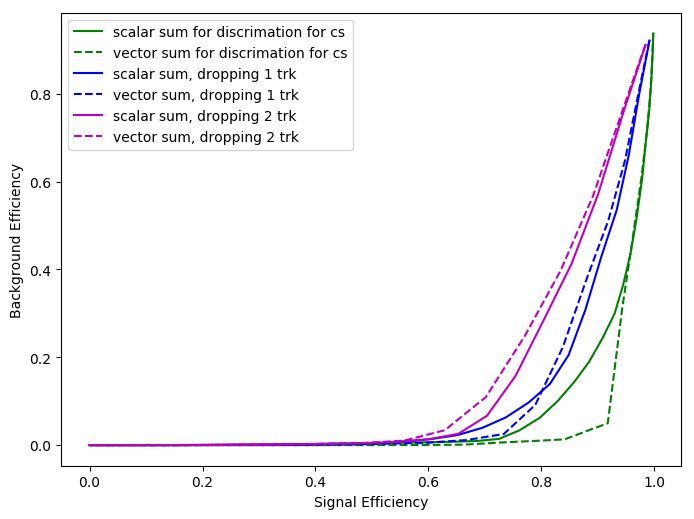

In [55]:
# Plot the ROC curves 

w = width(edges)
plt.figure(figsize=(8, 6), dpi=100)

# All the truth tracks
c_fpr_SS = inv_CDF(c_n_SS,w)
c_fpr_VS = inv_CDF(c_n_VS,w)

tpr_SS = inv_CDF(b_n_SS,w)
tpr_VS = inv_CDF(b_n_VS,w)
    
plt.plot(tpr_SS,c_fpr_SS,'g',label='scalar sum for discrimation for cs')
plt.plot(tpr_VS,c_fpr_VS,'g--',label='vector sum for discrimation for cs')

# Dropping 1 track
c_fpr_SS_1trk = inv_CDF(c_n_SS_1trk,w)
c_fpr_VS_1trk = inv_CDF(c_n_VS_1trk,w)

tpr_SS_1trk = inv_CDF(b_n_SS_1trk,w)
tpr_VS_1trk = inv_CDF(b_n_VS_1trk,w)
    
plt.plot(tpr_SS_1trk,c_fpr_SS_1trk,'b',label='scalar sum, dropping 1 trk')
plt.plot(tpr_VS_1trk,c_fpr_VS_1trk,'b--',label='vector sum, dropping 1 trk')

# Dropping 2 tracks
c_fpr_SS_2trk = inv_CDF(c_n_SS_2trk,w)
c_fpr_VS_2trk = inv_CDF(c_n_VS_2trk,w)

tpr_SS_2trk = inv_CDF(b_n_SS_2trk,w)
tpr_VS_2trk = inv_CDF(b_n_VS_2trk,w)
    
plt.plot(tpr_SS_2trk,c_fpr_SS_2trk,'m',label='scalar sum, dropping 2 trk')
plt.plot(tpr_VS_2trk,c_fpr_VS_2trk,'m--',label='vector sum, dropping 2 trk')

plt.xlabel('Signal Efficiency')
plt.ylabel('Background Efficiency')
plt.legend()
plt.show()

Conclusion: The scalar sum is wildly overcorrecting at the truth level, so to investigate why this is the case, I'm going to try to throw out one track per jet (since this was on average how many tracks JF was failing to reconstruct), and try remaking these truth level plots to see if the scalar correction again offers an improvement over the vector sum version of pPerp.

# Potential next steps
So I think this shows us that we need a different correction depending on the number of tracks
The reason why the scalar sum works so nice is that it's very close to the vector sum for hadros with few


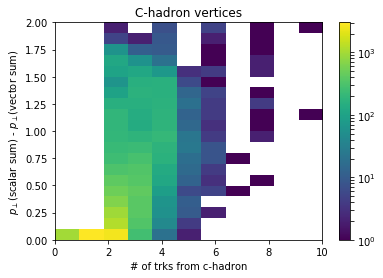

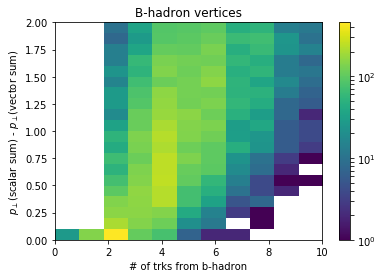

In [59]:
Nbins=[11,20]
range=[[0,10],[0,2]]

# pt_SS - pt_VS for charms
dpt_c = truth_df['pt_SS'][truth_df['jet_LabDrF']==4] - truth_df['pt'][truth_df['jet_LabDrF']==4]
plt.hist2d(truth_df['nTrks'][truth_df['jet_LabDrF']==4],dpt_c,bins=Nbins,range=range,norm=LogNorm())
plt.xlabel('# of trks from c-hadron')
plt.ylabel('$p_\perp$(scalar sum) - $p_\perp$(vector sum)')
plt.colorbar()
plt.title('C-hadron vertices')
plt.show()

dpt_b = truth_df['pt_SS'][truth_df['jet_LabDrF']==5] - truth_df['pt'][truth_df['jet_LabDrF']==5]
plt.hist2d(truth_df['nTrks'][truth_df['jet_LabDrF']==5],dpt_b,bins=Nbins,range=range,norm=LogNorm())
plt.xlabel('# of trks from b-hadron')
plt.ylabel('$p_\perp$(scalar sum) - $p_\perp$(vector sum)')
plt.colorbar()
plt.title('B-hadron vertices')
plt.show()

In [ ]:
# pt_SS - pt_VS for bs
dpt_b = truth_df['pt_SS'][truth_df['jet_LabDrF']==5] - truth_df['pt'][truth_df['jet_LabDrF']==5]
ax2.hist2d(truth_df['nTrks'][truth_df['jet_LabDrF']==5],dpt_b)

# Next plan: Overlay the mass and pt distributions w/o any of the cuts applied
(1) Raw m_ch

(2) Applying the formula m = sqrt(m_ch^2 + pt^2) + |pt| w/ J(r) cost fct

(3) Applying the formula m = sqrt(m_ch^2 + pt^2) + |pt| w/ J(r) + alpha pt^2 to determine pt

(4) Applying the formula m = sqrt(m_ch^2 + pt^2) + |pt| w/ J(r) + beta |pt| to determine pt

(5) Using the J(r) = 1 to wiggle the SV and determine pt that way

(6) The truth m_ch dist                      (only available for b+c hadrons)

(7) The truth m = sqrt(m_ch^2 + pt^2) + |pt| (only available for b+c hadrons)


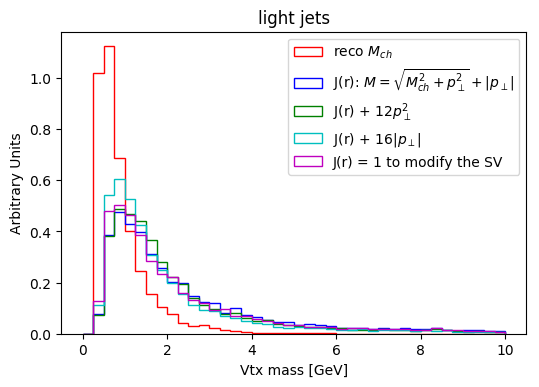

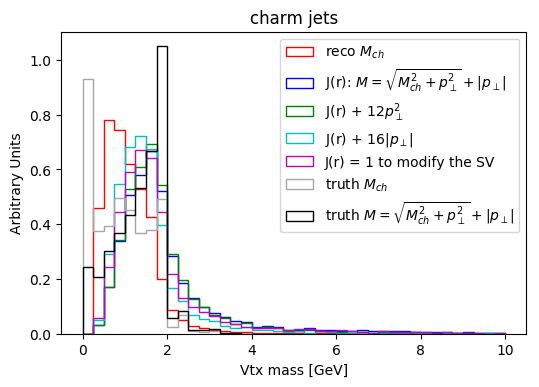

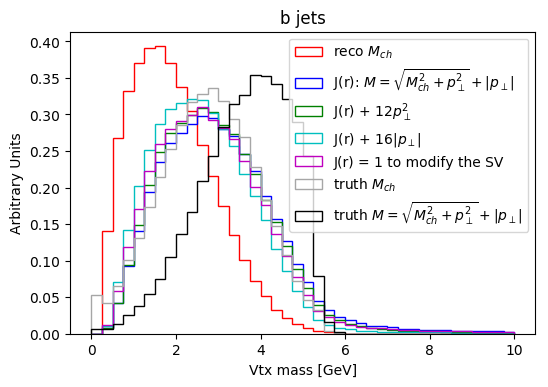

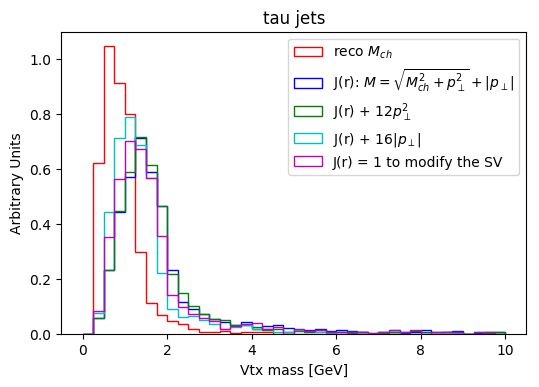

In [69]:
plt.close()
pdg_ids = [0,4,5,15]
titles  = ['light jets','charm jets','b jets','tau jets']

min = 0
max = 10
Nbins = 40
range = (min,max)

alpha=12
beta=16

for pdg_id,title in zip(pdg_ids,titles):

    # set up your figures
    fig = plt.figure(figsize=(6, 4), dpi=100)

    plt.hist(sv1_df_flat['m_ch'][sv1_df_flat['jet_pdg']==pdg_id],
             label='reco $M_{ch}$', color='r',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r): $M = \sqrt{M_{ch}^2 + p_\perp^2} + |p_\perp|$', color='b',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m_alpha12'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$p_\perp^2$'.format(alpha), color='g',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m_beta16'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$|p_\perp|$'.format(beta), color='c',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m_z1'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) = 1 to modify the SV'.format(beta), color='m',
             histtype='step',bins=Nbins,range=range,normed=True)
    
    if pdg_id == 4 or pdg_id == 5:
        
        hadron = 'b' if pdg_id == 5 else 'c'
        
        plt.hist(truth_df.loc[hadron]['m_ch'],
                 label='truth $M_{ch}$', color='0.65', # grey
                 histtype='step',bins=Nbins,range=range,normed=True)
        plt.hist(truth_df.loc[hadron]['m'],
                 label='truth $M = \sqrt{M_{ch}^2 + p_\perp^2} + |p_\perp|$', color='k',
                 histtype='step',bins=Nbins,range=range,normed=True)
    
    # prettify your histograms
    plt.xlabel('Vtx mass [GeV]')
    plt.ylabel('Arbitrary Units')
    plt.title(title)
    plt.legend()
    plt.show()



# Mitigating the tails:
To try to mitigate the tails on these distributions, implement the $M < 2*M_{ch}$ cut and see if this can help clean up the tails at all.

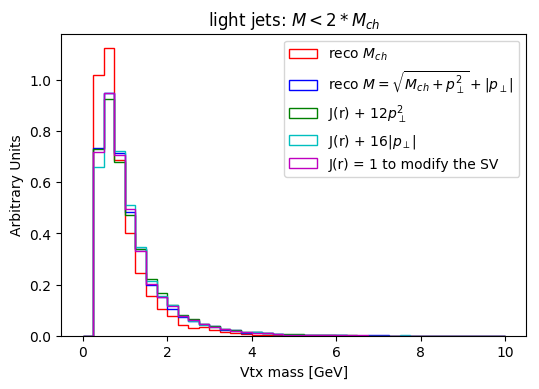

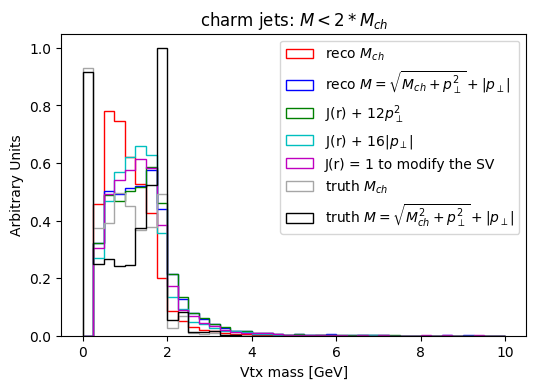

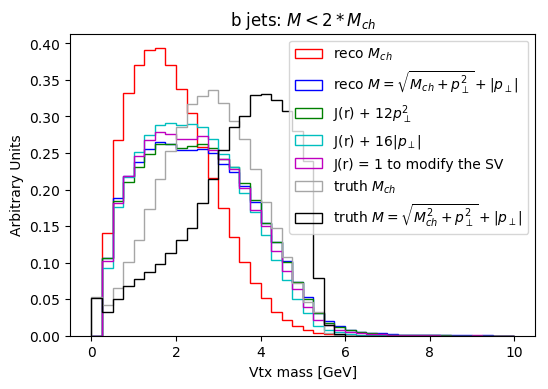

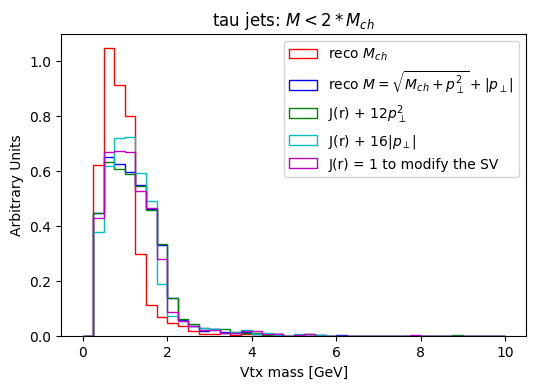

In [68]:
for pdg_id,title in zip(pdg_ids,titles):

    title = "{0}: {1}".format(title,'$M < 2*M_{ch}$')
    
    # set up your figures
    fig = plt.figure(figsize=(6, 4), dpi=100)

    plt.hist(sv1_df_flat['m_ch'][sv1_df_flat['jet_pdg']==pdg_id],
             label='reco $M_{ch}$', color='r',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m'].where(sv1_df_flat['m'] < 2*sv1_df_flat['m_ch'],other=sv1_df_flat['m_ch'])[sv1_df_flat['jet_pdg']==pdg_id],
             label='reco $M = \sqrt{M_{ch} + p_\perp^2} + |p_\perp|$', color='b',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m_alpha12'].where(sv1_df_flat['m_alpha12'] < 2*sv1_df_flat['m_ch'],other=sv1_df_flat['m_ch'])[sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$p_\perp^2$'.format(alpha), color='g',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m_beta16'].where(sv1_df_flat['m_beta16'] < 2*sv1_df_flat['m_ch'],other=sv1_df_flat['m_ch'])[sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$|p_\perp|$'.format(beta), color='c',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['m_z1'].where(sv1_df_flat['m_z1'] < 2*sv1_df_flat['m_ch'],other=sv1_df_flat['m_ch'])[sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) = 1 to modify the SV'.format(beta), color='m',
             histtype='step',bins=Nbins,range=range,normed=True)
    
    if pdg_id == 4 or pdg_id == 5:
        
        hadron = 'b' if pdg_id == 5 else 'c'
        
        plt.hist(truth_df.loc[hadron]['m_ch'],
                 label='truth $M_{ch}$', color='0.65', # grey
                 histtype='step',bins=Nbins,range=range,normed=True)
        plt.hist(truth_df.loc[hadron]['m'].where(truth_df.loc[hadron]['m'] < 2*truth_df.loc[hadron]['m_ch'],other=truth_df.loc[hadron]['m_ch']),
                 label='truth $M = \sqrt{M_{ch}^2 + p_\perp^2} + |p_\perp|$', color='k',
                 histtype='step',bins=Nbins,range=range,normed=True)
    
    # prettify your histograms
    plt.xlabel('Vtx mass [GeV]')
    plt.ylabel('Arbitrary Units')
    plt.title(title)
    plt.legend()
    plt.show()



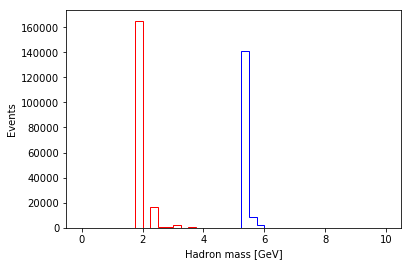

In [123]:
# Seeing how good we can possibly do... what is the actual hadron mass???
# I'm not overlaying these plots on the other one b/c they'd basically be delta functions, 
# so would obscure the other info that I'm trying to convey

plt.hist(truth_df.loc['b']['m_hadron'],color='b',
        histtype='step',bins=Nbins,range=range)
plt.hist(truth_df.loc['c']['m_hadron'],color='r',
         histtype='step',bins=Nbins,range=range)
plt.xlabel('Hadron mass [GeV]')
plt.ylabel('Events')
plt.show()


In [124]:
# Plot the p-perps for the various models

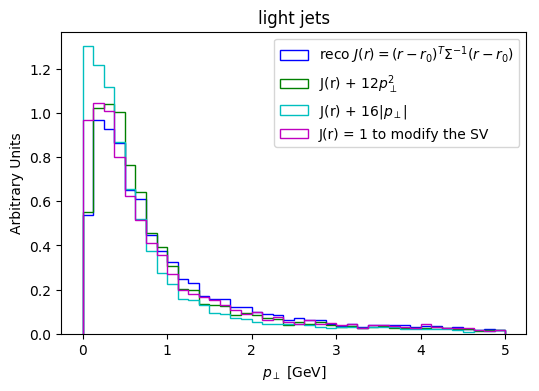

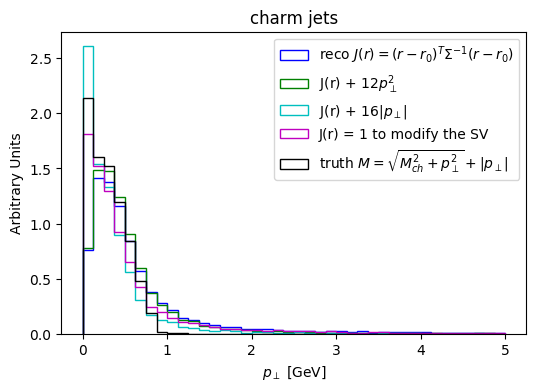

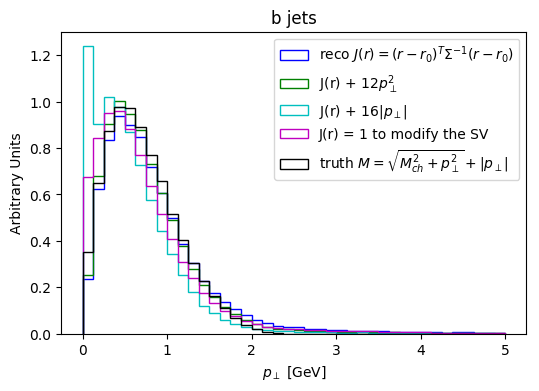

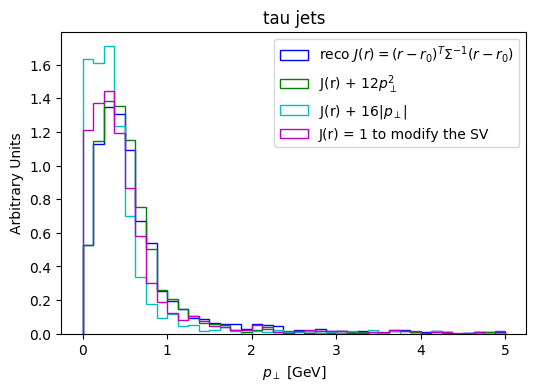

In [70]:
min = 0
max = 5
Nbins = 40
range = (min,max)

for pdg_id,title in zip(pdg_ids,titles):

    # set up your figures
    fig = plt.figure(figsize=(6, 4), dpi=100)

    plt.hist(sv1_df_flat['pt'][sv1_df_flat['jet_pdg']==pdg_id],
             label='reco $J(r) = (r-r_0)^T \Sigma^{-1} (r-r_0)$', color='b',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['pt_alpha12'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$p_\perp^2$'.format(alpha), color='g',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['pt_beta16'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$|p_\perp|$'.format(beta), color='c',
             histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(sv1_df_flat['pt_z1'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) = 1 to modify the SV'.format(beta), color='m',
             histtype='step',bins=Nbins,range=range,normed=True)
    
    if pdg_id == 4 or pdg_id == 5:
        
        hadron = 'b' if pdg_id == 5 else 'c'
        
        plt.hist(truth_df.loc[hadron]['pt'],
                 label='truth $M = \sqrt{M_{ch}^2 + p_\perp^2} + |p_\perp|$', color='k',
                 histtype='step',bins=Nbins,range=range,normed=True)
    
    # prettify your histograms
    plt.xlabel('$p_\perp$ [GeV]')
    plt.ylabel('Arbitrary Units')
    plt.title(title)
    plt.legend()
    plt.show()



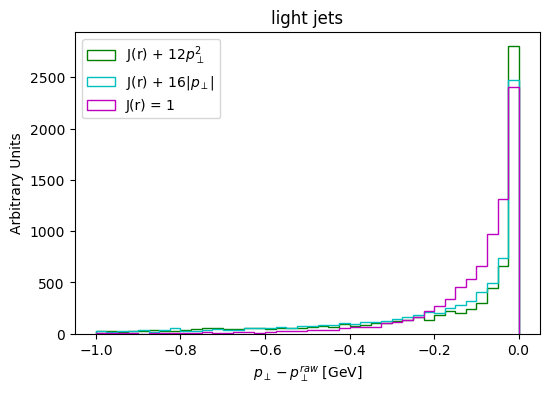

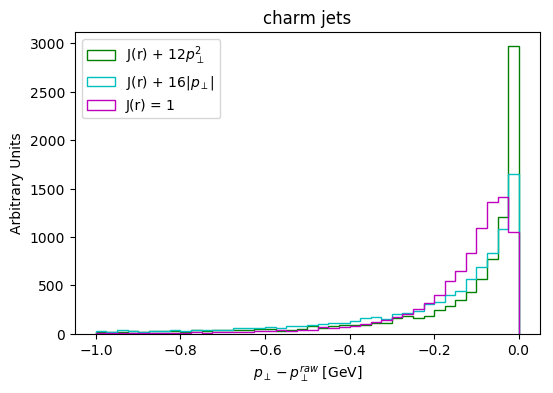

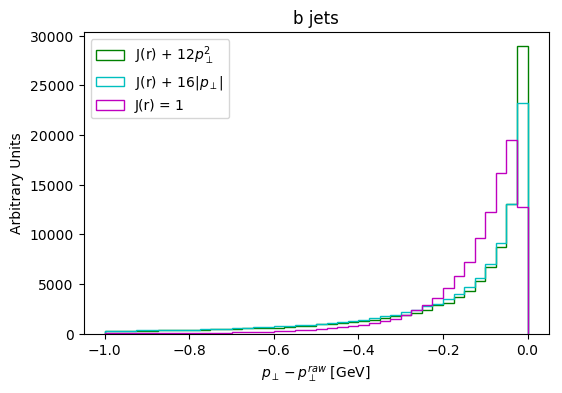

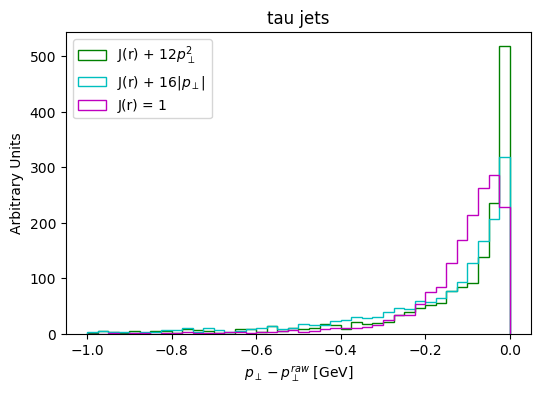

In [29]:
# Plot p-perp - p_perp for the nominal cost function

min = -1
max = 0
Nbins = 40
range = (min,max)

for pdg_id,title in zip(pdg_ids,titles):

    # set up your figures
    fig = plt.figure(figsize=(6, 4), dpi=100)

    plt.hist(sv1_df_flat['pt_alpha12'][sv1_df_flat['jet_pdg']==pdg_id] - sv1_df_flat['pt'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$p_\perp^2$'.format(alpha), color='g',
             histtype='step',bins=Nbins,range=range)
    plt.hist(sv1_df_flat['pt_beta16'][sv1_df_flat['jet_pdg']==pdg_id] - sv1_df_flat['pt'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) + {}$|p_\perp|$'.format(beta), color='c',
             histtype='step',bins=Nbins,range=range)
    plt.hist(sv1_df_flat['pt_z1'][sv1_df_flat['jet_pdg']==pdg_id] - sv1_df_flat['pt'][sv1_df_flat['jet_pdg']==pdg_id],
             label='J(r) = 1'.format(beta), color='m',
             histtype='step',bins=Nbins,range=range)

    # prettify your histograms
    plt.xlabel('$p_\perp - p_\perp^{raw}$ [GeV]')
    plt.ylabel('Arbitrary Units')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

# Pre-process the JF data.

I think I should be able to put this info in a similar format as the SV1 df that I created, although now there will be more SVs.

Just for reference: these are the branches that I used from SV1:

jet_sv1_branches = ['PVx','PVy','PVz',                        'jet_sv1_Nvtx','jet_sv1_vtx_x','jet_sv1_vtx_y','jet_sv1_vtx_z','jet_sv1_vtxm',                 'jet_sv1_vtx_cov0','jet_sv1_vtx_cov1','jet_sv1_vtx_cov2','jet_sv1_vtx_cov3','jet_sv1_vtx_cov4','jet_sv1_vtx_cov5',
'jet_LabDr_HadF','jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_algo']

and the resultant vars in the df are also shown below.

In [32]:
'''
Return the theta and phi for the r0 unit vector for one of the jets

    x: np.array for SVs x positions
    y:              SVs y positions
    z:              SVs z positions
    dx:             SVs x errors
    dy:             SVs y errors
    dz:             SVs z errors
    
Outputs:
    theta
    phi

'''
def get_r0(x,y,z,dx,dy,dz):
    

    # This inline function returns an np array for the length of the fitted SV position along the
    # flight direction
    ri = lambda theta,phi: np.divide( np.divide( np.sin(theta)*np.cos(phi)*x, np.power(dx,2) )
                                    + np.divide( np.sin(theta)*np.sin(phi)*y, np.power(dy,2) )
                                    + np.divide( np.cos(theta)*z,             np.power(dz,2) ), 
                                      np.power(dx / (np.sin(theta)*np.cos(phi)), -2)
                                    + np.power(dy / (np.sin(theta)*np.sin(phi)), -2)
                                    + np.power(dz /  np.cos(theta),              -2) )

    # print "ri(0,0) = {}".format(ri(0,0))
    
    
    # The cost function that we're trying to minimize the fit theta and phi
    # The input b is a 2d array with b[0]=theta and b[1]=phi
    J = lambda b: np.sum( np.power(np.divide(ri(b[0],b[1])*np.sin(b[0])*np.cos(b[1]) - x, dx),2)
                        + np.power(np.divide(ri(b[0],b[1])*np.sin(b[0])*np.sin(b[1]) - y, dy),2)
                        + np.power(np.divide(ri(b[0],b[1])*np.cos(b[0]) - z, dz),2) )
    
    # print "J(.1,.1) = {}".format(J(np.array([0.1,0.1])))
    
    # Get a sensible initial guess
    
    
    # Call the minimizer
    res = minimize(J,np.array([0.1,0.1]))
    
    # If the minimizer, was successful, return the fitted result
    if res.success:
        return res.x
    
    else:
        print res.message
        return np.array([-99,-99])

In [31]:
m_pi = 139.57

# Find the scalar sum of the pPerps of the tracks used by JF
def pPerpScalarSum(jet_trk_pt,jet_trk_eta,jet_trk_phi,jet_trk_alg,r_theta,r_phi):
        
    # Initialize the Vectors to 0s
    r  = Vector3(1,1,1)
    r.SetPtThetaPhi(1.,r_theta,r_phi)
    
    p  = LorentzVector()
    pi = LorentzVector()

    ntrk = 0
    
    pPerpSS = 0
    lead_piPerp = 0

    for trk_pt,trk_eta,trk_phi,trk_alg in zip(jet_trk_pt,jet_trk_eta,jet_trk_phi,jet_trk_alg):

        # Check don't use tracks not used by SV1
        if trk_alg & 0b10000 == 0:
            continue

        ntrk = ntrk + 1
            
        pi.SetPtEtaPhiM(trk_pt,trk_eta,trk_phi,m_pi)
        piPerp = (pi.Vect()).Perp(r)
        pPerpSS = pPerpSS + piPerp

        if piPerp > lead_piPerp:
            lead_piPerp = piPerp 
        
        p = p + pi

    # Scale from MeV to GeV
    return pPerpSS*0.001, p.Mag()*0.001,lead_piPerp*0.001

In [22]:
loadData = False

if not loadData:

    # Select the desired branches 
    jf_branches = ['PV_jf_x','PV_jf_y','PV_jf_z',
                'jet_jf_vtx_x','jet_jf_vtx_y','jet_jf_vtx_z',
                'jet_jf_vtx_x_err','jet_jf_vtx_y_err','jet_jf_vtx_z_err',
                'jet_jf_VTXsize','jet_jf_m','jet_jf_mUncorr','mass_first_vtx','mass_second_vtx',
                'jet_jf_theta','jet_jf_phi','jet_jf_ntrkAtVx','jet_jf_vtx_ntrk','jet_jf_nvtx',
                'jet_LabDr_HadF','jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_algo',
                'jet_pt','jet_eta']

    # Convert the Ntuple to an nd array
    data = root2array(filepath,branches=jf_branches)

    # Go from an ndarray to a pandas data frame
    jf_df = pd.DataFrame(data)

    # First need to convert the event level PV to jet level varaibles
    # This function just makes PV into a list of length of the jet before applying flatten
    for col in ['PV_jf_x','PV_jf_y','PV_jf_z']:
        jf_df[col] =  [map(lambda n_vertices: PV_x, n_vertices ) for (_, (PV_x,n_vertices))  in jf_df[[col,'jet_jf_VTXsize']].iterrows()]

    # Flatten the array to jet level variables
    jf_df_flat = pd.DataFrame({k: flatten(c) for k, c in jf_df.iteritems()})
    jf_df_flat = jf_df_flat[jf_df.keys()][jf_df_flat['jet_jf_VTXsize']!=0]
    jf_df_flat.reset_index(inplace=True,drop=True)
    
    # Not sure what this does... but need for non-negative masses in mUncorr
    jf_df_flat = jf_df_flat[jf_df.keys()][jf_df_flat['jet_jf_nvtx']==0]
    jf_df_flat.reset_index(inplace=True,drop=True)
    
    # Just look at the first 100 events to go faster :) 
    # jf_df_flat = jf_df_flat[:100]
    
    # Get the flight direction
    
    # First find the theta and phi
#     res = np.array( map(lambda args: get_r0(*args),jf_df_flat[['jet_jf_vtx_x','jet_jf_vtx_y','jet_jf_vtx_z',
#                 'jet_jf_vtx_x_err','jet_jf_vtx_y_err','jet_jf_vtx_z_err']].values) )
    
#     jf_df_flat['r0_theta'] = pd.Series(res[:,0])
#     jf_df_flat['r0_phi']   = pd.Series(res[:,1])
    
#     # Then report the (x,y,z) for the unit vector r0
#     jf_df_flat['r0_x'] = pd.Series( np.sin(jf_df_flat['r0_theta'])*np.cos(jf_df_flat['r0_phi']) )
#     jf_df_flat['r0_y'] = pd.Series( np.sin(jf_df_flat['r0_theta'])*np.sin(jf_df_flat['r0_phi']) )
#     jf_df_flat['r0_z'] = pd.Series( np.cos(jf_df_flat['r0_theta']) )

    jf_df_flat['r0_x'] = pd.Series( np.sin(jf_df_flat['jet_jf_theta'])*np.cos(jf_df_flat['jet_jf_phi']) ) #+ jf_df_flat['PV_jf_x']
    jf_df_flat['r0_y'] = pd.Series( np.sin(jf_df_flat['jet_jf_theta'])*np.sin(jf_df_flat['jet_jf_phi']) ) #+ jf_df_flat['PV_jf_y']
    jf_df_flat['r0_z'] = pd.Series( np.cos(jf_df_flat['jet_jf_theta']) )                                  #+ jf_df_flat['PV_jf_z']

    # Get the vector for the charged particles
    p_arr = np.array(map(lambda args: p_ch_trks(*args,boolMask=0b10000), jf_df_flat[['jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_algo']].values))
    jf_df_flat['p_x'] = p_arr[:,0]
    jf_df_flat['p_y'] = p_arr[:,1]
    jf_df_flat['p_z'] = p_arr[:,2]

    # Get the direction of pt rel to the flight path
    jf_df_flat['pt'] = pd.Series(p_perp(jf_df_flat[['p_x','p_y','p_z']].values,jf_df_flat[['r0_x','r0_y','r0_z']].values))

    # Scale the vtx mass to GeV
    jf_df_flat['jet_jf_mUncorr'] = jf_df_flat['jet_jf_mUncorr'].apply(MeVtoGeV)
    jf_df_flat['jet_jf_m'] = jf_df_flat['jet_jf_m'].apply(MeVtoGeV)
    
    # Final (super exciting) step: Find the corrected mass :D
    jf_df_flat['m_MY_TRY'] = pd.Series( m_corr(jf_df_flat['jet_jf_mUncorr'],jf_df_flat['pt']) )
    
    # Apparently the actual code is using a scalar sum of p_perps (I have NO idea why...)
    # but try to implement it to see if this is in fact the case!
    ptSS_mch = np.array(map(lambda args: pPerpScalarSum(*args) , jf_df_flat[['jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_algo','jet_jf_theta','jet_jf_phi']].values))
    
    jf_df_flat['pt_scalarSum'] = pd.Series(ptSS_mch[:,0])
    jf_df_flat['m_ch'] = pd.Series(ptSS_mch[:,1])
    jf_df_flat['lead_piPerp'] = pd.Series(ptSS_mch[:,2])
    
    # Try to implement the correction from JF w/ the scalar sum version of pPerp
    jf_df_flat['m_raw_SS'] = pd.Series(m_corr(jf_df_flat['jet_jf_mUncorr'],jf_df_flat['pt_scalarSum']))

    # Only apply this correction if mUncorr is > 0 (b/c that's what the JF factory code does)
    jf_df_flat['m_raw_SS'] = jf_df_flat['m_raw_SS'].where(jf_df_flat['jet_jf_mUncorr'] > 0,other=jf_df_flat['jet_jf_mUncorr'])
    
    # Don't let the correction go above 10 GeV
    jf_df_flat['m_scaled_SS'] = jf_df_flat['m_raw_SS'].apply(scaleM)
        
    # Other useful variables to understand the topology of the event:
    # Need to mask with the algo thingie
    jf_df_flat['lead_pi'] = pd.Series( map(lambda x: np.max( (x[0]*np.cosh(x[1]))*(x[2] & 0b10000)/16 ) ,jf_df_flat[['jet_trk_pt','jet_trk_eta','jet_trk_algo']].values)).apply(MeVtoGeV) 
    jf_df_flat['sum_pi']  = pd.Series(np.linalg.norm(p_arr,axis=1))
    jf_df_flat['jet_p']   = pd.Series(jf_df_flat['jet_pt']*np.cosh(jf_df_flat['jet_eta'])).apply(MeVtoGeV)
       
#     # Delete the columns that you don't want to save
#     del_cols = ['jet_sv1_vtx_cov0','jet_sv1_vtx_cov1','jet_sv1_vtx_cov2','jet_sv1_vtx_cov3','jet_sv1_vtx_cov4','jet_sv1_vtx_cov5',
#                'jet_sv1_vtxm','index','jet_sv1_Nvtx','jet_trk_pt','jet_trk_eta','jet_trk_phi','jet_trk_algo']
#     for col in jf_branches:
#         del sv1_df_flat[col]

#     # Rename some columns 
#     sv1_df_flat.rename(index=str, columns={"jet_sv1_vtx_x": "SVx", "jet_sv1_vtx_y": "SVy", 
#                                            "jet_sv1_vtx_z": "SVz", "jet_LabDr_HadF": "jet_pdg"},inplace=True)

    # Save the df
    jf_df_flat.to_hdf('jf_df.h5', 'data')

# if loadData is True, load a previously formatted SV1 dataframe from an HDF5 file
else:
    jf_df_flat = pd.read_hdf('jf_df.h5', 'data')

NameError: global name 'pPerpScalarSum' is not defined

In [30]:
jf_df_flat[['sum_pi','lead_pi','jet_p']][:5]

,sum_pi,lead_pi,jet_p
0,41.908555,41.908555,270.753094
1,34.840524,17.948859,130.547883
2,41.840890,12.907230,96.453219
3,9.215056,9.215057,133.543422
4,4.841624,3.469111,46.174188


In [ ]:
jf_df_flat.to_hdf('jf_df.h5', 'data')

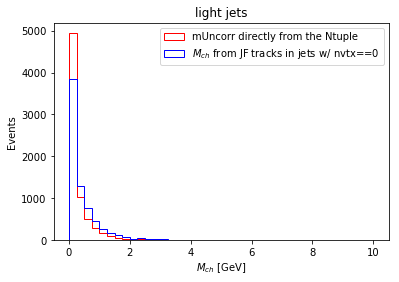

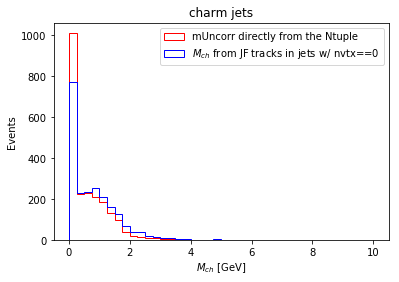

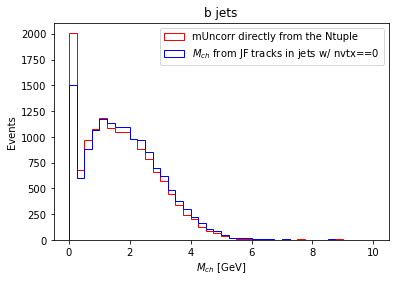

In [9]:
Nbins=40
range=(0,10)

pdg_ids = [0,4,5]
titles  = ['light jets','charm jets','b jets']

for pdg_id,title in zip(pdg_ids,titles):

    plt.hist(jf_df_flat['jet_jf_mUncorr'][jf_df_flat['jet_LabDr_HadF']==pdg_id],
                 label='mUncorr directly from the Ntuple', color='r',
                 histtype='step',bins=Nbins,range=range)
    plt.hist(jf_df_flat['m_ch'][jf_df_flat['jet_LabDr_HadF']==pdg_id],
                 label='$M_{ch}$ from JF tracks in jets w/ nvtx==0', color='b',
                 histtype='step',bins=Nbins,range=range)

    plt.title(title)
    plt.xlabel('$M_{ch}$ [GeV]')
    plt.ylabel('Events')
    plt.legend()
    plt.show()

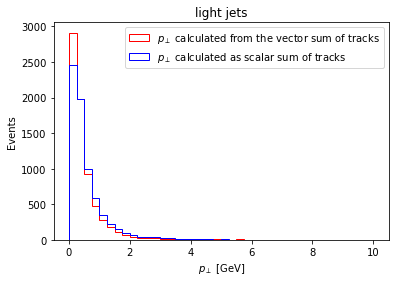

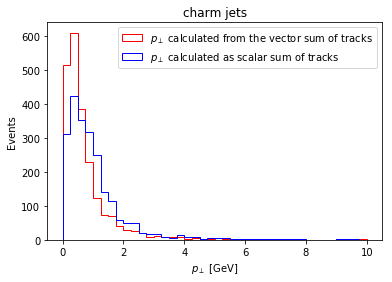

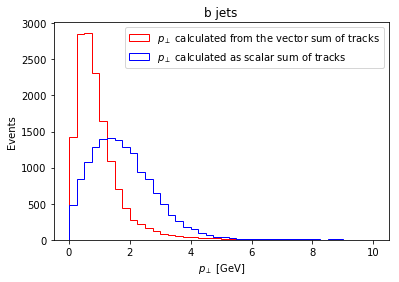

In [10]:
# Also plot the p_perp vs. the pPerp from the scalar sum

for pdg_id,title in zip(pdg_ids,titles):

    plt.hist(jf_df_flat['pt'][jf_df_flat['jet_LabDr_HadF']==pdg_id],
                 label='$p_\perp$ calculated from the vector sum of tracks', color='r',
                 histtype='step',bins=Nbins,range=range)
    plt.hist(jf_df_flat['pt_scalarSum'][jf_df_flat['jet_LabDr_HadF']==pdg_id],
                 label='$p_\perp$ calculated as scalar sum of tracks', color='b',
                 histtype='step',bins=Nbins,range=range)

    plt.title(title)
    plt.xlabel('$p_\perp$ [GeV]')
    plt.ylabel('Events')
    plt.legend()
    plt.show()

In [5]:
# This function accepts the bin edges (length N+1)
# and outputs the width of the bins as an
width = lambda edges: edges[1:] - edges[:-1]

# This function accepts two arrays for the height and width of the bin, and
# outputs a vector for the cdf of this histogram
inv_CDF = lambda n,w: 1-np.array([sum(n[0:i+1]*w[0:i+1]) for i in np.arange(0,n.size)])

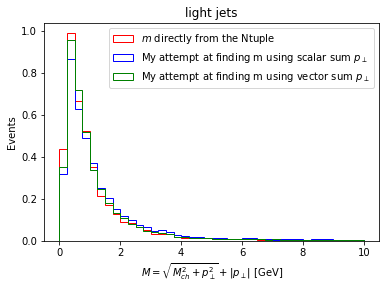

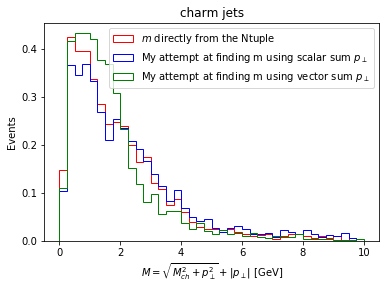

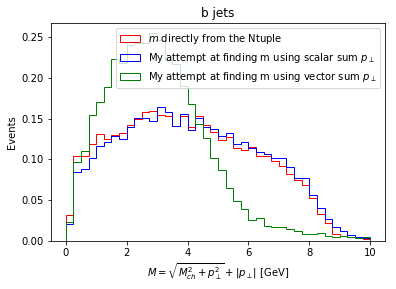

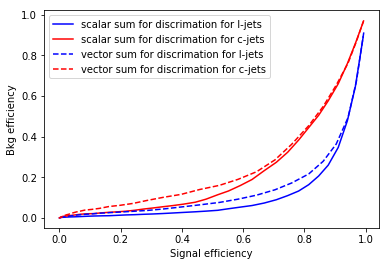

In [12]:
# The different variables I want to do for the discrimination power
#jet_jf_m,m_scaled_SS,m_MY_TRY


for pdg_id,title in zip(pdg_ids,titles):

    
    n_SS,edges_SS,_ = plt.hist(jf_df_flat['jet_jf_m'][jf_df_flat['jet_LabDr_HadF']==pdg_id],
                 label='$m$ directly from the Ntuple', color='r',
                 histtype='step',bins=Nbins,range=range,normed=True)
    plt.hist(jf_df_flat['m_scaled_SS'][jf_df_flat['jet_LabDr_HadF']==pdg_id],
                 label='My attempt at finding m using scalar sum $p_\perp$', color='b',
                 histtype='step',bins=Nbins,range=range,normed=True)
    n_VS,edges_VS,_ = plt.hist(jf_df_flat['m_MY_TRY'][jf_df_flat['jet_LabDr_HadF']==pdg_id],
                 label='My attempt at finding m using vector sum $p_\perp$', color='g',
                 histtype='step',bins=Nbins,range=range,normed=True)

    # Compute the widths of these bins given the edges
    w_SS = width(edges_SS)
    w_VS = width(edges_VS)
    
    plt.title(title)
    plt.xlabel('$M = \sqrt{M_{ch}^2 + p_\perp^2} + |p_\perp|$ [GeV]')
    plt.ylabel('Events')
    plt.legend()
    plt.show()

    
    # Then get the true positive rate from sum of the b-curve,
    # and two of the false positve rates from summing up the l and c-curves
    if pdg_id == 0:
        l_fpr_SS = inv_CDF(n_SS,w_SS)
        l_fpr_VS = inv_CDF(n_VS,w_VS)
    elif pdg_id == 4:
        c_fpr_SS = inv_CDF(n_SS,w_SS)
        c_fpr_VS = inv_CDF(n_VS,w_VS)
    elif pdg_id == 5:
        tpr_SS = inv_CDF(n_SS,w_SS)
        tpr_VS = inv_CDF(n_VS,w_VS)
    
# Plot the ROC curves 
plt.plot(tpr_SS,l_fpr_SS,'b',label='scalar sum for discrimation for l-jets')
plt.plot(tpr_SS,c_fpr_SS,'r',label='scalar sum for discrimation for c-jets')

plt.plot(tpr_VS,l_fpr_VS,'b--',label='vector sum for discrimation for l-jets')
plt.plot(tpr_VS,c_fpr_VS,'r--',label='vector sum for discrimation for c-jets')

plt.xlabel('Signal efficiency')
plt.ylabel('Bkg efficiency')
plt.legend(loc='upper left')
plt.show()

# ROC Curve Analysis

So the formula that implements the correction $m$ using the scalar sum for $p_\perp$ dominates over the one using the vector sum for $p_\perp$.

I thought that this was the case light and charm jets should have fewer tracks than, and hence will be less impacted by the difference of $p_\perp$ calculated with the scalar rather than the vector sum. However, this scalar sum should be quite a bit larger for the b-jets, and hence the corrected mass for the b jets pulled to the larger values, which is significant b/c it's the spreading out of these distributions that contributes to the discrimination power.

To further investigate / understand why this is the case, I started by looking at how much the max $p_{\perp i}$ contributes to the total $p_\perp$.


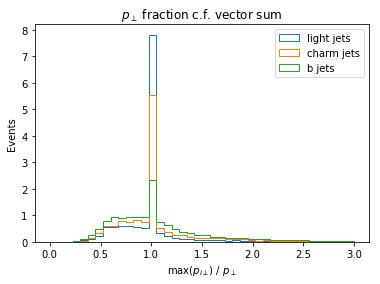

In [10]:
# Plot the distribution of the leading trk pPerp vs. te pPerp (vectorially summed)
for pdg_id,title in zip(pdg_ids,titles):

    plt.hist(jf_df_flat['lead_piPerp'][jf_df_flat['jet_LabDr_HadF']==pdg_id]/jf_df_flat['pt'][jf_df_flat['jet_LabDr_HadF']==pdg_id],
                 label=title,
                 histtype='step',bins=40,range=(0,3),normed=True)

plt.title('$p_\perp$ fraction c.f. vector sum')
plt.xlabel('max($p_{i\perp}$) / $p_\perp$')
plt.ylabel('Events')
plt.legend()
plt.show()


I think because there are fewer light and charm tracks, this means that it's more likely that all of the $p_\perp$ is accounted for by a single track.

This ratio can be less than 1 when c.f. the vector summed $p_\perp$, but is strictly less than 1 when c.f. the scalar summed $p_\perp$.


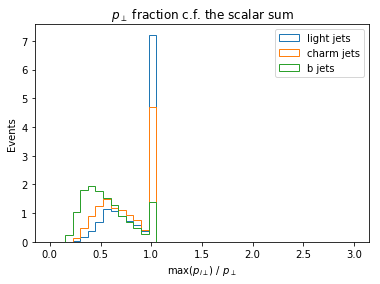

In [24]:
# Plot the distribution of the leading trk pPerp vs. te pPerp (vectorially summed)
for pdg_id,title in zip(pdg_ids,titles):

    plt.hist(jf_df_flat['lead_piPerp'][jf_df_flat['jet_LabDr_HadF']==pdg_id]/jf_df_flat['pt_scalarSum'][jf_df_flat['jet_LabDr_HadF']==pdg_id],
                 label=title,
                 histtype='step',bins=40,range=(0,3),normed=True)

plt.title('$p_\perp$ fraction c.f. the scalar sum')
plt.xlabel('max($p_{i\perp}$) / $p_\perp$')
plt.ylabel('Events')
plt.legend()
plt.show()

Something that's interesting in this plot is that the max$p_{i \perp}$ is quite a harder for the light than the c and b jets, suggesting that the radiation cone is more spread out for light than charm and b-jets.

This could just be because the momentum distributions in this sample are softer for the light and charm jets, as we saw in the truthStudies nb.

But we would expect the longitudinal vector to have more energy for the tracks from the b than those from the l and c-jets. The variables that we're going to use to investigate this are

- $ \frac{ \max (p_i) }{ \sum_i p_i } $ 

- $ \frac{ \max (E_i) }{ \sum_i E_i } $

- $ \frac{ \max (p_i) }{ p_{jet} } $

- $ \frac{ \max (E_i) }{ E_{jet} } $

Note: I'm not sure why I need to make the plots w/r.t. the momentum and energy...

Just try to add an extra leaf for the max $p_i$!

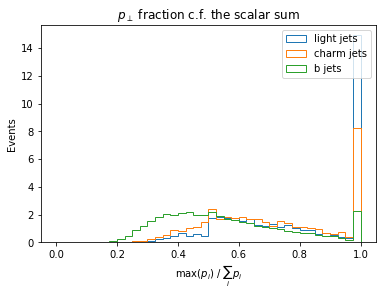

In [34]:
for pdg_id,title in zip(pdg_ids,titles):

    plt.hist(jf_df_flat['lead_pi'][jf_df_flat['jet_LabDr_HadF']==pdg_id]/jf_df_flat['sum_pi'][jf_df_flat['jet_LabDr_HadF']==pdg_id],
                 label=title,
                 histtype='step',bins=40,range=(0,1),normed=True)

plt.title('$p_\perp$ fraction c.f. the scalar sum')
plt.xlabel('max($p_{i}$) / $\sum_i p_i$')
plt.ylabel('Events')
plt.legend()
plt.show()

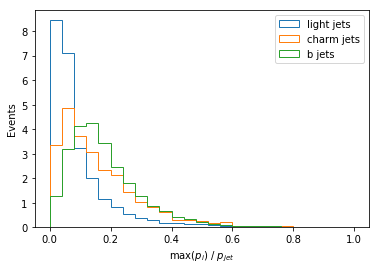

In [12]:
for pdg_id,title in zip(pdg_ids,titles):

    plt.hist(jf_df_flat['lead_pi'][jf_df_flat['jet_LabDr_HadF']==pdg_id]/jf_df_flat['jet_p'][jf_df_flat['jet_LabDr_HadF']==pdg_id],
                 label=title,
                 histtype='step',bins=25,range=(0,1.0),normed=True)

plt.xlabel('max($p_{i}$) / $p_{jet}$')
plt.ylabel('Events')
plt.legend()
plt.show()

So the leading track for the b-jet carries a larger fraction of the jet's energy, but a smaller fraction of the momentum of the tracks. This is because the b-meson carries a large fraction of the energy (70%) of the b-jet, but the since there are fewer tracks in the c, the momentum / track is larger for c-jets (as demonstrated in Giacinto's thesis).

# Quantifying the discrimination power

Although the scalar sum of the $p_\perp$ curves has a slightly larger tail for the charm jets, since it shifts the b-jets value closer to 5, this means that it could have a better discrimination power b/w b and c and and l. :D

So look at different cuts, and make the ROC curves for each of these events!

In [ ]:
# 